#🔬 Исследование влияния отрицаний на классификацию настроений в русском языке

## 1. Введение и постановка задачи

**Автор:** Абдульминев Данис Русланович  
**Дата начала:** 25 июля 2025

### Цель

Изучить влияние различных подходов к обработке отрицаний на качество классификации настроений с учетом специфики используемой модели.

---

### 📋 Описание проблемы

Отрицания в тексте существенно меняют смысл высказываний:  
- "Фильм хороший" → позитивный отзыв  
- "Фильм **не** хороший" → негативный отзыв

**Проблема:**  
Базовые подходы к обработке текста часто игнорируют этот аспект, что может снижать качество автоматической классификации.

---

### 🎯 Исследовательские вопросы

1. Как обработка отрицаний влияет на качество классификации?
2. Поможет ли специальный токен `[NEG]` после отрицательных слов лучше захватывать контекст?
3. В каких случаях модели ошибаются из-за отрицаний?
4. Влияет ли архитектура модели (`ruBERT-tiny` против `ruBERT-tiny2`) на чувствительность к отрицаниям и общее качество классификации?

---

### 🔬 Гипотезы

- **H1:** Удаление отрицаний приведёт к ухудшению метрик классификации.
- **H2:** Добавление токена `[NEG]` после отрицательных слов повысит способность модели распознавать изменение смысла.
- **H3:** Подход с токенами `[NEG]` особенно улучшит работу на негативных примерах.
- **H4:** Более новая/модифицированная модель `ruBERT-tiny2` покажет лучшие результаты на задачах с учетом отрицаний по сравнению с `ruBERT-tiny`.

---

### 📊 Данные и модели

#### Датасет

**Источник:** Russian Sentiment Dataset  
- **Описание:** Русскоязычные отзывы с разметкой тональности  
- **Классы:** 0 (нейтральный), 1 (позитивный), 2 (негативный)  
- **Структура:** текст, метка, источник, длина  
- **Размер:** [будет указан после загрузки]

#### Модели

- **ruBERT-tiny:** компактная BERT-модель для русского языка (Hugging Face)
- **ruBERT-tiny2:** обновленная версия той же архитектуры (Hugging Face)
- **Задача:** дообучение для трёхклассной классификации
- **Токенизаторы:** соответствующие AutoTokenizer для каждой модели

---

### ⚙️ План эксперимента

**Варианты предобработки:**
1. `text_basic` — базовая очистка и лемматизация
2. `text_no_neg` — удаление отрицаний
3. `text_with_neg` — вставка `[NEG]` после отрицательных слов

**Варианты моделей:**  
- `ruBERT-tiny`  
- `ruBERT-tiny2`

**Разделение данных:** train (70%) / validation (15%) / test (15%)  
**Метрики:** Accuracy, F1-weighted, F1-macro

---

### 📈 Ожидаемые результаты

- Сравнение метрик между способами обработки отрицаний для разных моделей
- Анализ ошибок и примеры, связанных с отрицаниями
- Визуализация внимания к отрицаниям
- Сравнение `ruBERT-tiny` и `ruBERT-tiny2` в этой задаче
- Практические рекомендации по обработке отрицаний с учетом архитектуры модели

---

### 📚 Содержание

1. Введение и постановка задачи ← здесь
2. Настройка окружения
3. Подготовка данных
4. Разведочный анализ
5. Предобработка текста
6. Токенизация и датасеты
7. Обучение моделей
8. Оценка результатов
9. Анализ ошибок
10. Выводы


## 2. Настройка окружения

В этом блоке:

- Устанавливаем и подключаем основные Python-библиотеки для анализа, предобработки и обучения
- Загружаем исходный датасет из Google Drive (путь: `/content/drive/MyDrive/sentiment_dataset.csv`)
- Проверяем доступность GPU для ускоренного обучения
- Задаём фиксированный `random seed` для полной воспроизводимости

---

In [1]:
# --- 2.1. Установка ПАКЕТОВ (единственный install-блок в ноутбуке!) ---
!pip install -q pymorphy3 swifter nltk transformers datasets evaluate wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 101.6 MB/s eta 0:00:00


In [2]:
# --- 2.2. ЕДИНЫЙ импорт всех библиотек с структурированием ---

# Системные и служебные
import os
import sys
import warnings
import random
import pickle # Используется для сохранения/загрузки датасетов
import time
from collections import Counter
import json # Используется для сохранения метрик
from datetime import datetime

# Data Science/DataFrame
import numpy as np
import pandas as pd

# ML/DS визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# NLP/ML/Deep Learning
import torch
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset, DatasetDict
import evaluate # Используется для метрик в Trainer

# Морфология/нормализация
import pymorphy3
import nltk
from nltk.corpus import stopwords

# Внешние сервисы/интеграции
import swifter
import wandb # Используется для логирования экспериментов
from google.colab import drive

# Для регулярных выражений (используется в предобработке)
import re

In [3]:
# --- 2.3. СТИЛИ и suppress warnings ---
warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set_palette("Set2")


In [4]:
# --- 2.4. Проверка и настройка GPU, фиксирование random seed ---

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    cuda_name = torch.cuda.get_device_name(0)
    print(f"✅ CUDA доступна. GPU: {cuda_name}")
else:
    print("⚠️ CUDA недоступна, обучение будет идти на CPU")


✅ CUDA доступна. GPU: NVIDIA A100-SXM4-40GB


In [5]:
# --- 2.5. Инициализация ресурсов для морфологии и nltk ---

nltk.download('stopwords', quiet=True)
morph = pymorphy3.MorphAnalyzer()
russian_stopwords = set(stopwords.words('russian'))


In [6]:
# --- 2.6. Монтирование Google Drive один раз в ноутбуке ---

drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# --- 2.7. Задание ПУТИ и загрузка исходного датасета ---
DATA_PATH = "/content/drive/MyDrive/colab_sentiment_negation_study/sentiment_dataset.csv"
assert os.path.isfile(DATA_PATH), f"❌ Файл не найден по адресу: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print(f"✅ Датасет успешно загружен! Размер: {df.shape[0]} строк, {df.shape[1]} столбцов\n")


✅ Датасет успешно загружен! Размер: 290458 строк, 3 столбцов



In [8]:
# --- 2.8. Контроль версий для полнейшей воспроизводимости ---
print("Версии библиотек:")
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("torch:", torch.__version__)
import transformers
print("transformers:", transformers.__version__)
import datasets
print("datasets:", datasets.__version__)
print("wandb:", wandb.__version__)

Версии библиотек:
pandas: 2.2.2
numpy: 2.0.2
torch: 2.6.0+cu124
transformers: 4.55.0
datasets: 4.0.0
wandb: 0.21.0


## 3. Подготовка данных

В этом блоке:

- Проверяем содержимое и структуру датасета
- Анализируем баланс классов и состав по источникам
- Добавляем колонку с длиной текста
- Визуализируем ключевые аспекты распределения данных

---

In [ ]:
# --- 3.1. Общая структура и быстрый анализ датасета ---

print("🗂 Столбцы в датасете:", df.columns.tolist())
print(f"📏 Размер: {df.shape[0]} строк, {df.shape[1]} столбцов\n")

print("🔹 Примеры первых 5 записей:")
display(df.head(5))

print(f"\n🔍 Количество пропусков в датасете: {df.isna().sum().sum()}")
print("\n📝 Типы данных:")
print(f"  - 'text':  {df['text'].dtype}")
print(f"  - 'label': {df['label'].dtype}")
print(f"  - 'src':   {df['src'].dtype}")


🗂 Столбцы в датасете: ['text', 'label', 'src']
📏 Размер: 290458 строк, 3 столбцов

🔹 Примеры первых 5 записей:


,text,label,src
0,"Пальто красивое, но пришло с дырой в молнии. П...",0,rureviews
1,"Очень долго шел заказ,ждала к новому году,приш...",0,rureviews
2,"Могу сказать одно, брюки нормальные, НО они бы...",0,rureviews
3,"Доставка быстрая, меньше месяца. Заказывали ра...",0,rureviews
4,Мне не очень понравилось это платье. Размер ...,0,rureviews



🔍 Количество пропусков в датасете: 0

📝 Типы данных:
  - 'text':  object
  - 'label': int64
  - 'src':   object



🗃️ Подсчет источников данных ('src'):
src
rureviews                    86436
geo                          63408
perekrestok                  54462
anime                        39027
kinopoisk                    18999
rusentiment                  11729
linis                         7194
ru-reviews-classification     4718
sber                          2043
news                          1518
bank                           924
Name: count, dtype: int64


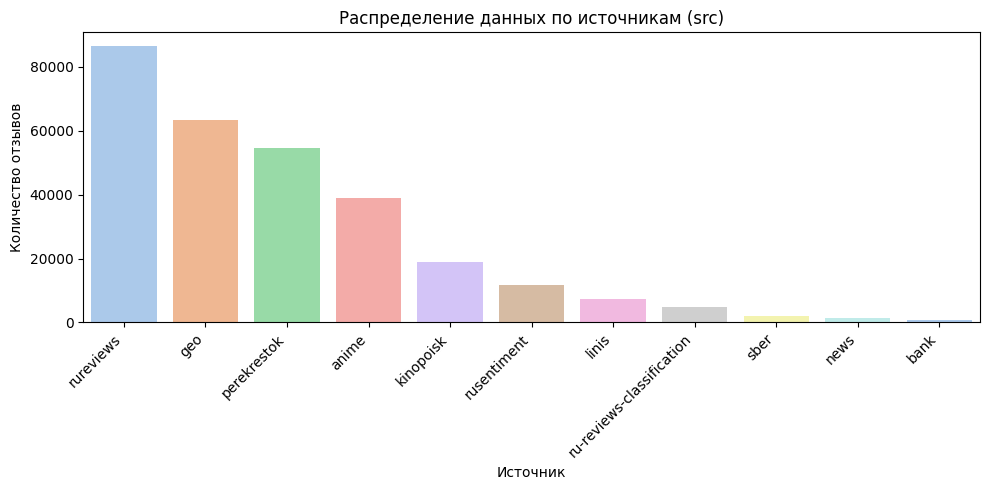

In [ ]:
# --- 3.2. Приведение типов и анализ источников ---

df['text'] = df['text'].astype(str)
df['src'] = df['src'].astype(str)

print("\n🗃️ Подсчет источников данных ('src'):")
src_counts = df['src'].value_counts()
print(src_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=src_counts.index, y=src_counts.values, palette='pastel')
plt.title('Распределение данных по источникам (src)')
plt.xlabel('Источник')
plt.ylabel('Количество отзывов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


🟩🟨🟥 Распределение по целевым классам:
Нейтральный: 33.25% (96589 примеров)
Позитивный: 33.35% (96877 примеров)
Негативный: 33.39% (96992 примеров)


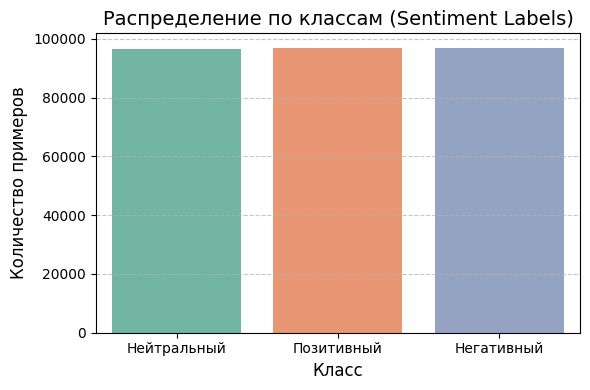

In [ ]:
# --- 3.3. Анализ и визуализация распределения по классам ---

label_map = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
label_map_rus = {0: 'Нейтральный', 1: 'Позитивный', 2: 'Негативный'}

print("🟩🟨🟥 Распределение по целевым классам:")
label_counts = df['label'].value_counts().sort_index()
label_percent = df['label'].value_counts(normalize=True).sort_index() * 100

for label, percent in label_percent.items():
    label_name = label_map_rus[label]
    print(f"{label_name}: {percent:.2f}% ({label_counts[label]} примеров)")

plt.figure(figsize=(6, 4))
sns.barplot(x=[label_map_rus[i] for i in label_counts.index], y=label_counts.values, palette='Set2')
plt.title('Распределение по классам (Sentiment Labels)', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество примеров', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


📏 Статистика длины текстов (в словах):
count    290458.000000
mean         51.152714
std          56.124131
min           0.000000
25%          11.000000
50%          26.000000
75%          73.000000
max         279.000000
Name: text_length, dtype: float64


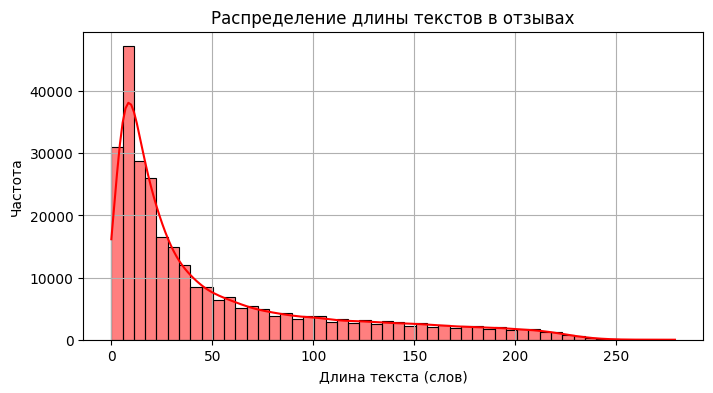

In [ ]:
# --- 3.4. Добавление и анализ длины текста ---

df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

print("📏 Статистика длины текстов (в словах):")
print(df['text_length'].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df['text_length'], bins=50, kde=True, color='red')
plt.title('Распределение длины текстов в отзывах')
plt.xlabel('Длина текста (слов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


## 4. Разведочный анализ данных

В этом блоке:
- Рассматриваем примеры отзывов по классам
- Анализируем встречаемость отрицаний (слова "не", "никогда", "нет" и др.)
- Исследуем разнообразие длин и структуры текстов, языковые особенности и источники

---

In [ ]:
# --- 4.1. Примеры из каждого класса ---

print("\n📝 Примеры отзывов по классам:")
for label in sorted(df['label'].unique()):
    print('='*45)
    print(f"Класс {label} — {label_map[label]} ({label_map_rus[label]})")
    samples = df[df['label'] == label]['text'].dropna().sample(3, random_state=label)
    for i, text in enumerate(samples, 1):
        short = text if len(text) <= 150 else text[:150] + "..."
        print(f"{i}. {short}\n")



📝 Примеры отзывов по классам:
Класс 0 — Neutral (Нейтральный)
1. К сожалению в последнем заказе не очень хороший порей: очень маленькая "съедобная" часть и огромный зеленый букет.

2. 14.12.2016, 17:16
ЕАБР принят в члены KASE на фондовый рынок и деривативы
Алматы. 14 декабря. ИНТЕРФАКС-КАЗАХСТАН - Совет директоров Казахстанской фон...

3. очень тонкие.... скорее тонкий стрейч.... качество так себе, торчат нитки

Класс 1 — Positive (Позитивный)
1. Супер компания!качественная продукция!супер персонал все быстро и четко объяснили и подобрали технологию


2. Почему не могу обновить?хоть и вай фай и все сделал правильно

3. Достоинства:
Вкусно. Хорошо оформлено. Цена-80 руб.
Недостатки:
Мало


Класс 2 — Negative (Негативный)
1. Свитер пришёл достаточно быстро, но качество оставляет желать лучшего((( короткий,воротник топорщится, очень широкий( я разочарована

2. доставка месяц до СПб. в груди большое очень. в бедрах сильно жмёт. на параметры ог 90 от 80 об 100 размер Л неподошел. деньги в

In [ ]:
# --- 4.2. Автоматическое извлечение потенциальных отрицаний ---

import re
from collections import Counter

def extract_negation_words_from_data(df, min_frequency=20, max_length=8):
    """
    Извлекает наиболее частые потенциальные отрицательные слова из корпуса.
    """
    negation_patterns = [r'\bне\w*\b', r'\bни\w*\b', r'\bнет\b', r'\bн[еиёо]\w*\b']
    word_counter = Counter()
    for text in df['text'].dropna():
        text_lower = text.lower()
        for pattern in negation_patterns:
            matches = re.findall(pattern, text_lower)
            for word in matches:
                if 2 <= len(word) <= max_length:
                    word_counter[word] += 1
    frequent_words = [w for w, c in word_counter.items() if c >= min_frequency]
    return word_counter, frequent_words

word_stats, auto_negations = extract_negation_words_from_data(df)

# Фильтрация только реальных отрицаний вручную + базовые частицы
manual_filter = {'не', 'нет', 'ни', 'никогда', 'никто', 'никакой', 'ничего', 'ничто', 'нельзя', 'невозможно', 'никак', 'нигде', 'никуда'}
final_negations = list(set(auto_negations) & manual_filter).copy()
final_negations += list({'не', 'нет', 'ни'} - set(final_negations))
final_negations = list(sorted(set(final_negations)))
print(f"\nСписок отрицаний для анализа: {final_negations}")



Список отрицаний для анализа: ['не', 'нельзя', 'нет', 'ни', 'нигде', 'никак', 'никакой', 'никогда', 'никто', 'никуда', 'ничего', 'ничто']


In [ ]:
# --- 4.3. Подсчет частоты отрицаний и создание признака has_negation ---

def count_texts_with_negations_precise(df, negation_list):
    """
    Выводит статистику по каждому отрицанию: сколько текстов содержат его как отдельное слово.
    """
    results = {}
    for word in negation_list:
        pat = r'\b' + re.escape(word) + r'\b'
        count = df['text'].str.contains(pat, case=False, na=False, regex=True).sum()
        pct = (count / len(df)) * 100
        results[word] = {'texts_count': count, 'text_percentage': pct}
    return results

precise_stats = count_texts_with_negations_precise(df, final_negations)
print("Топ-10 отрицаний по частоте (в % текстов):")
top_neg = sorted(precise_stats.items(), key=lambda x: x[1]['text_percentage'], reverse=True)[:10]
for word, stats in top_neg:
    print(f"  {word:<12} | {stats['texts_count']:<8} | {stats['text_percentage']:.2f} %")

def contains_negation_precise(text, negation_list=final_negations):
    text_lower = text.lower()
    for neg in negation_list:
        pattern = r'\b' + re.escape(neg) + r'\b'
        if re.search(pattern, text_lower):
            return True
    return False

df['has_negation'] = df['text'].apply(contains_negation_precise)


Топ-10 отрицаний по частоте (в % текстов):
  не           | 176816   | 60.87 %
  нет          | 34223    | 11.78 %
  ничего       | 16868    | 5.81 %
  ни           | 16001    | 5.51 %
  нельзя       | 4549     | 1.57 %
  никогда      | 4522     | 1.56 %
  никто        | 4173     | 1.44 %
  никак        | 3222     | 1.11 %
  никакой      | 2633     | 0.91 %
  нигде        | 1087     | 0.37 %


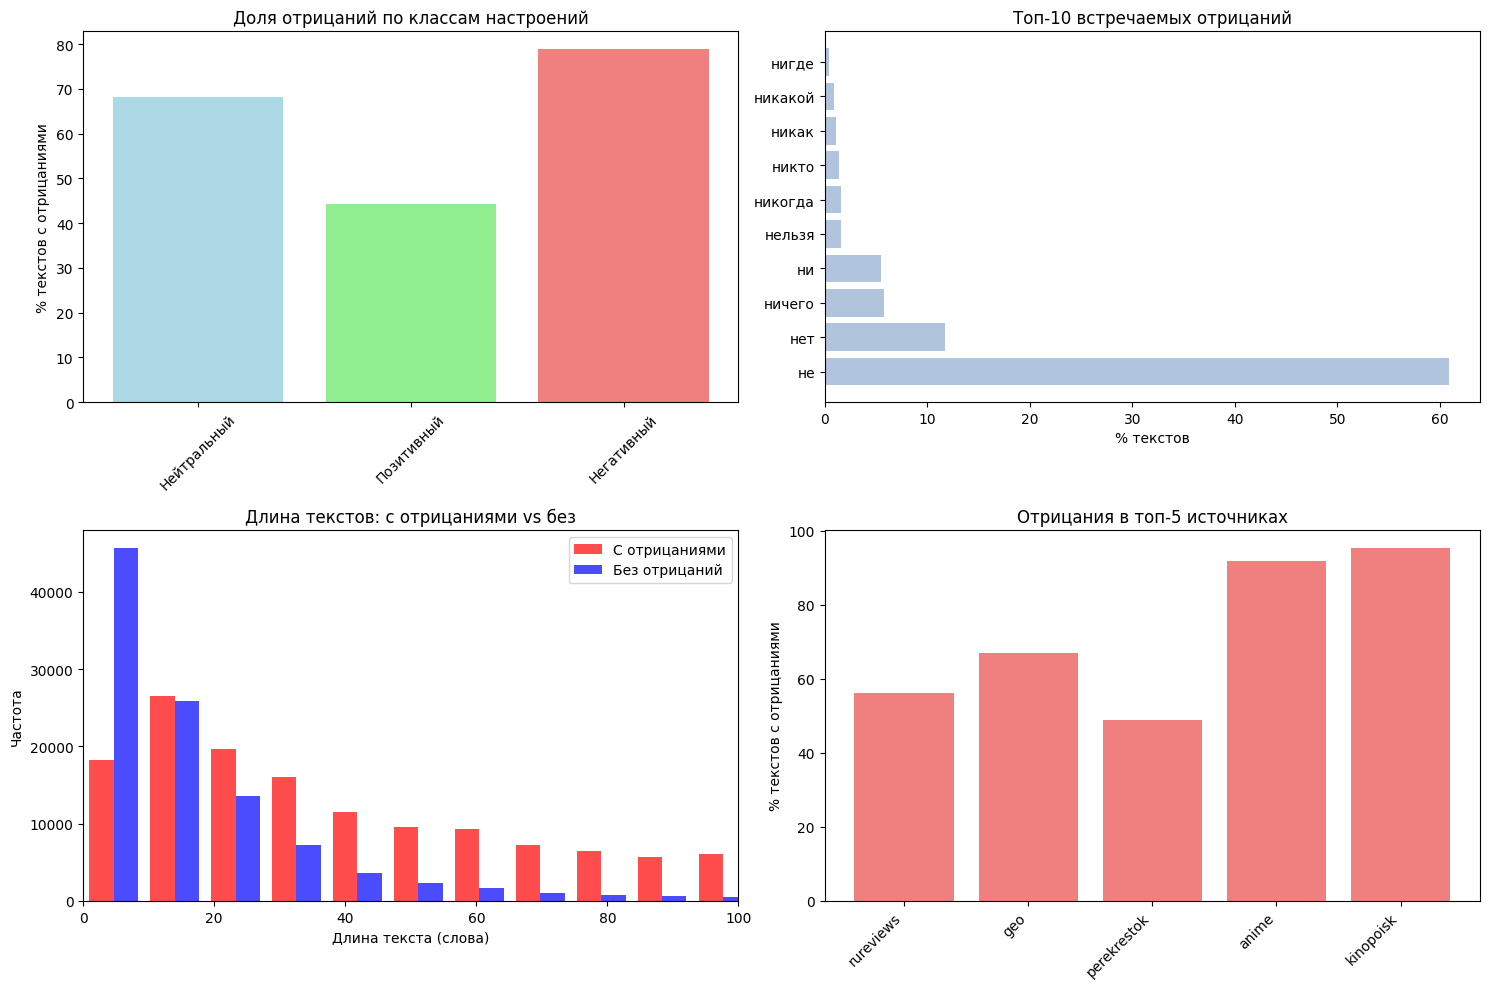

In [ ]:
# --- 4.4. Визуализация: вхождение отрицаний по классам, длины, источники ---

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1 — % текстов с отрицаниями по классам
neg_by_class = df.groupby('label')['has_negation'].agg(['sum', 'count'])
neg_by_class['percentage'] = (neg_by_class['sum'] / neg_by_class['count']) * 100
ax1.bar([label_map_rus[i] for i in neg_by_class.index], neg_by_class['percentage'],
        color=['lightblue', 'lightgreen', 'lightcoral'])
ax1.set_ylabel('% текстов с отрицаниями')
ax1.set_title('Доля отрицаний по классам настроений')
ax1.tick_params(axis='x', rotation=45)

# 2 — Топ-10 отрицаний по частоте
words, percentages = zip(*[(w, v['text_percentage']) for w, v in top_neg])
ax2.barh(words, percentages, color='lightsteelblue')
ax2.set_xlabel('% текстов')
ax2.set_title('Топ-10 встречаемых отрицаний')

# 3 — Длины текстов с/без отрицаний
with_neg = df[df['has_negation']]['text_length']
without_neg = df[~df['has_negation']]['text_length']
ax3.hist([with_neg, without_neg], bins=30, alpha=0.7,
         label=['С отрицаниями', 'Без отрицаний'], color=['red', 'blue'])
ax3.set_xlabel('Длина текста (слова)')
ax3.set_ylabel('Частота')
ax3.set_title('Длина текстов: с отрицаниями vs без')
ax3.legend()
ax3.set_xlim(0, 100)

# 4 — Анализ источников (топ-5)
top_5_sources = df['src'].value_counts().head(5).index
source_neg_data = [(df[df['src'] == src]['has_negation'].mean() * 100) for src in top_5_sources]
source_labels = [src[:15] + "..." if len(src) > 15 else src for src in top_5_sources]
ax4.bar(range(5), source_neg_data, color='lightcoral')
ax4.set_xticks(range(5))
ax4.set_xticklabels(source_labels, rotation=45, ha='right')
ax4.set_ylabel('% текстов с отрицаниями')
ax4.set_title('Отрицания в топ-5 источниках')

plt.tight_layout()
plt.show()


## 5. Предобработка текста

В этом блоке:

- Формируем три разных варианта предобработанных текстов для тестирования гипотез о влиянии отрицаний.
- Применяем базовые шаги: очистку, лемматизацию, удаление стоп-слов.
- Реализуем три стратегии обращения с отрицаниями:
    1. **text_standard**: удаление отрицаний в рамках стандартного списка стоп-слов
    2. **text_preserve_neg**: сохранение всех отрицательных частиц в тексте
    3. **text_neg_token**: замена всех отрицательных слов на специальный токен `[NEG]`
- На выходе: три новых столбца в датафрейме df


---

In [9]:
# --- 5.1. Импорт необходимых ресурсов и подготовка списков ---
final_negations = ['не', 'нельзя', 'нет', 'ни', 'нигде', 'никак', 'никакой', 'никогда', 'никто', 'никуда', 'ничего', 'ничто']
# Финальный список отрицаний, найденных в EDA (см. блок 4)
negation_words = sorted(final_negations)

# Стоп-слова без отрицаний (для подхода 2 и 3)
stopwords_wo_neg = russian_stopwords - set(negation_words)

print(f"Список используемых отрицательных слов: {negation_words}")
print(f"Кол-во стоп-слов с отрицаниями: {len(russian_stopwords)}, без отрицаний: {len(stopwords_wo_neg)}")


Список используемых отрицательных слов: ['не', 'нельзя', 'нет', 'ни', 'нигде', 'никак', 'никакой', 'никогда', 'никто', 'никуда', 'ничего', 'ничто']
Кол-во стоп-слов с отрицаниями: 151, без отрицаний: 145


In [10]:
# --- 5.2. Функции базовой очистки и лемматизации текста ---

def clean_text(text: str) -> str:
    """
    Очищает текст: приведение к нижнему регистру, убирает url/email/номера, оставляет только русские символы и цифры.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\+?\d[\d\s\-\(\)]{7,}\d', '', text)
    text = re.sub(r'[^а-яё0-9\s\.\!\?\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def lemmatize_and_filter_stopwords(text: str, stopwords_set: set) -> str:
    """
    Лемматизация и фильтрация слов в списке stopwords.
    """
    words = text.split()
    return ' '.join(
        morph.parse(word)[0].normal_form
        for word in words
        if morph.parse(word)[0].normal_form not in stopwords_set and len(word) > 1
    )


In [22]:
# --- 5.3. Функции трёх стратегий обработки отрицаний ---

def create_standard_text(text):
    """Удаляет все стоп-слова, включая отрицания"""
    cleaned = clean_text(text)
    return lemmatize_and_filter_stopwords(cleaned, russian_stopwords)

def create_preserve_negations_text(text):
    """Сохраняет отрицания — удаляет все, кроме negation_words"""
    cleaned = clean_text(text)
    return lemmatize_and_filter_stopwords(cleaned, stopwords_wo_neg)

def create_negation_token_text(text):
    """
    Заменяет все встреченные отрицания на [NEG].
    После лемматизации — фильтрация как preserve_neg, далее замена в финальном токенизированном тексте.
    Последовательные отрицания заменяются одним [NEG].
    """
    cleaned = clean_text(text)
    processed = lemmatize_and_filter_stopwords(cleaned, stopwords_wo_neg)
    words = processed.split()
    processed_words = []
    prev_was_neg = False
    for word in words:
        is_neg = word in negation_words
        if is_neg:
            if not prev_was_neg:
                processed_words.append('[NEG]')
            prev_was_neg = True
        else:
            processed_words.append(word)
            prev_was_neg = False
    return ' '.join(processed_words)

In [23]:
# --- 5.4. Проверка работы функций на примерах ---

test_examples = [
    "Фильм не понравился, никогда не посоветую.",
    "Отличный фильм! Очень понравился.",
    "Неплохой фильм, но ничего особенного.",
    "Не могу сказать, что фильм плохой, но и не хороший."
]
for i, text in enumerate(test_examples, 1):
    print(f"\nПример {i}: '{text}'")
    print("-" * 50)
    print("text_standard :", create_standard_text(text))
    print("preserve_neg  :", create_preserve_negations_text(text))
    print("neg_token     :", create_negation_token_text(text))



Пример 1: 'Фильм не понравился, никогда не посоветую.'
--------------------------------------------------
text_standard : фильм понравиться посоветую.
preserve_neg  : фильм не понравиться никогда не посоветую.
neg_token     : фильм [NEG] понравиться [NEG] посоветую.

Пример 2: 'Отличный фильм! Очень понравился.'
--------------------------------------------------
text_standard : отличный фильм! очень понравился.
preserve_neg  : отличный фильм! очень понравился.
neg_token     : отличный фильм! очень понравился.

Пример 3: 'Неплохой фильм, но ничего особенного.'
--------------------------------------------------
text_standard : неплохой фильм особенного.
preserve_neg  : неплохой фильм ничего особенного.
neg_token     : неплохой фильм [NEG] особенного.

Пример 4: 'Не могу сказать, что фильм плохой, но и не хороший.'
--------------------------------------------------
text_standard : мочь сказать фильм плохой хороший.
preserve_neg  : не мочь сказать фильм плохой не хороший.
neg_token     : 

In [ ]:
# --- 5.5. Применение всех трёх подходов ко всему датасету (с прогресс-баром) ---

import swifter
print("Применяем три подхода предобработки ко всему датасету...")

df['text_standard'] = df['text'].swifter.progress_bar(True, desc="Standard").apply(create_standard_text)
df['text_preserve_neg'] = df['text'].swifter.progress_bar(True, desc="Preserve_NEG").apply(create_preserve_negations_text)
df['text_neg_token'] = df['text'].swifter.progress_bar(True, desc="NEG_token").apply(create_negation_token_text)
print("✅ Предобработка завершена!")

Применяем три подхода предобработки ко всему датасету...


Standard:   0%|          | 0/290458 [00:00<?, ?it/s]

Preserve_NEG:   0%|          | 0/290458 [00:00<?, ?it/s]

NEG_token:   0%|          | 0/290458 [00:00<?, ?it/s]

✅ Предобработка завершена!


In [ ]:
# --- 5.6. Анализ результатов для всех подходов ---

# Показываем примеры из текста с наличием отрицаний
print("\nПримеры результатов предобработки для текстов с отрицаниями:\n", "="*60)
neg_examples = df[df['has_negation']].sample(5, random_state=42)
for idx, row in neg_examples.iterrows():
    print(f"Исходный: {row['text'][:80]}{'...' if len(row['text']) > 80 else ''}")
    print(f"Standard:     {row['text_standard'][:70]}")
    print(f"Preserve neg: {row['text_preserve_neg'][:70]}")
    print(f"NEG token:    {row['text_neg_token'][:70]}")
    print('-'*60)



Примеры результатов предобработки для текстов с отрицаниями:
Исходный: Я-а-а не знаю, как это оценивать ^_^"Ладно, начнём. В далёких ранних 2010х на ан...
Standard:     я-а- знать это оценивать ладный начнём. далёкий ранний 2010ха анимемаг
Preserve neg: я-а- не знать это оценивать ладный начнём. далёкий ранний 2010ха аниме
NEG token:    я-а- [NEG] знать это оценивать ладный начнём. далёкий ранний 2010ха ан
------------------------------------------------------------
Исходный: Эх, вот и The End. И даже поцелуя не было. ЦЕА?? Романтика в этой манхве так себ...
Standard:     эх поцелуй было. цеа?? романтика манхв драка отличный каждый глава жда
Preserve neg: эх поцелуй не было. цеа?? романтика манхв драка отличный каждый глава 
NEG token:    эх поцелуй [NEG] было. цеа?? романтика манхв драка отличный каждый гла
------------------------------------------------------------
Исходный: Шикарный молочный шоколад (не тот, что делают в России под маркой Милка) и печен...
Standard:     шикарный м

In [ ]:
# --- 5.7. Сравнительная статистика по результатам предобработки ---

text_columns = ['text_standard', 'text_preserve_neg', 'text_neg_token']
print("📊 Сравнительная статистика по длинам предобработанных текстов:")

for col in text_columns:
    df[f"{col}_len"] = df[col].apply(lambda x: len(x.split()))
    stats = df[f"{col}_len"].describe()[['mean', '50%', 'std']].round(1)
    print(f"{col:<17} | Средняя: {stats['mean']}, Медиана: {stats['50%']}, Std: {stats['std']}")

print("\n🔍 Проверка потерь отрицаний и вставок [NEG]:")
for col in text_columns:
    count_neg_words = sum(df[col].str.count(f'\\b{neg}\\b').sum() for neg in negation_words)
    print(f"{col:<17} | Отрицаний сохранено: {count_neg_words}")

neg_token_col = 'text_neg_token'
neg_tokens_total = df[neg_token_col].str.count(r'\[NEG\]').sum()
texts_with_neg_token = (df[neg_token_col].str.contains(r'\[NEG\]')).sum()
print(f"\nВставок [NEG]: всего {neg_tokens_total}, текстов с [NEG]: {texts_with_neg_token}")


📊 Сравнительная статистика по длинам предобработанных текстов:
text_standard     | Средняя: 33.3, Медиана: 18.0, Std: 35.6
text_preserve_neg | Средняя: 35.0, Медиана: 19.0, Std: 37.2
text_neg_token    | Средняя: 34.9, Медиана: 19.0, Std: 37.1

🔍 Проверка потерь отрицаний и вставок [NEG]:
text_standard     | Отрицаний сохранено: 39226
text_preserve_neg | Отрицаний сохранено: 557046
text_neg_token    | Отрицаний сохранено: 16839

Вставок [NEG]: всего 507477, текстов с [NEG]: 183571


In [ ]:
# --- 5.8. Сохранение предобработанного датафрейма на Google Drive ---

from google.colab import drive
import os
from datetime import datetime

# Монтируем Google Drive
drive.mount('/content/drive', force_remount=True)

# Папка для сохранения
GDRIVE_SAVE_PATH = "/content/drive/MyDrive/colab_sentiment_negation_study/processed_data/"
os.makedirs(GDRIVE_SAVE_PATH, exist_ok=True)

# Формируем название файла с временной меткой
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"processed_sentiment_data_{timestamp}.csv"
full_save_path = os.path.join(GDRIVE_SAVE_PATH, filename)

# Сохраняем DataFrame
try:
    df.to_csv(full_save_path, index=False, sep='|')
    print(f"✅ DataFrame сохранён в: {full_save_path}")
except Exception as e:
    print(f"❌ Ошибка при сохранении DataFrame: {e}")


Mounted at /content/drive
✅ DataFrame сохранён в: /content/drive/MyDrive/colab_sentiment_negation_study/processed_data/processed_sentiment_data_20250731_1340.csv


## 6. Токенизация и подготовка датасетов
В этом блоке:
- Формируем расширенный токенизатор с `[NEG]` для обеих моделей
- Подбираем оптимальный `max_length`
- Токенизируем варианты Standard/Preserve_Neg/Neg_Token
- Стратифицированно делим на train/validation/test
- Сохраняем всё на Google Drive для обучения
---


In [ ]:
# --- 6.1. Импорт, монтирование диска, чтение данных ---



PROCESSED_DATA_PATH = f"{full_save_path}"
assert os.path.isfile(PROCESSED_DATA_PATH), f"❌ Файл не найден по адресу: {PROCESSED_DATA_PATH}"
df = pd.read_csv(PROCESSED_DATA_PATH, sep='|')
print(f"✅ Предобработанный датасет загружен: {df.shape[0]} строк, {df.shape[1]} столбцов")

✅ Предобработанный датасет загружен: 290458 строк, 11 столбцов


In [ ]:
# --- 6.2 Конфигурация моделей и основные параметры ---

MODEL_CONFIGS = {
    "tiny1": {
        "model_name": "cointegrated/rubert-tiny",
        "drive_dir": "/content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny1/"
    },
    "tiny2": {
        "model_name": "cointegrated/rubert-tiny2",
        "drive_dir": "/content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny2/"
    }
}
textcols = ['text_standard', 'text_preserve_neg', 'text_neg_token']
tags = ['Standard', 'Preserve_Neg', 'Neg_Token']


In [ ]:
# --- 6.3 Функция для создания расширенного токенизатора с [NEG] ---

def build_tokenizer_with_neg(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if '[NEG]' not in tokenizer.get_vocab():
        tokenizer.add_tokens(['[NEG]'])
    neg_token_id = tokenizer.convert_tokens_to_ids('[NEG]')
    print(f"Vocab size: {len(tokenizer)}, ID [NEG]: {neg_token_id} (модель: {model_name})\nТест:", tokenizer.tokenize('Это не хорошо, но [NEG] важно.'))
    return tokenizer, neg_token_id

In [ ]:
# --- 6.4 Функция оценки оптимальной max_length по токенам ---

def estimate_maxlen(df, columns, tokenizer, max_samples=2000):
    lens = []
    for col in columns:
        if col not in df: continue
        samples = df[col].dropna().sample(min(max_samples, len(df)), random_state=42)
        lengths = [len(tokenizer.tokenize(str(t))) for t in samples]
        lens.append(lengths)
        print(f"{col}: средняя {np.mean(lengths):.1f}, медиана {np.median(lengths):.0f}, 95% {np.percentile(lengths,95):.0f}, макс {np.max(lengths)}")
    max95 = max(np.percentile(l,95) for l in lens)
    return int(min(max95, 256))

In [ ]:
# --- 6.5. Стратифицированное разделение на train/val/test ---

def stratified_split(df, test_size=0.2, val_size=0.2, seed=42):
    trainval_idx, test_idx = train_test_split(
        np.arange(len(df)), test_size=test_size, stratify=df['label'], random_state=seed)
    train_idx, val_idx = train_test_split(
        trainval_idx, test_size=val_size, stratify=df.iloc[trainval_idx]['label'], random_state=seed)
    return train_idx, val_idx, test_idx

In [ ]:
# --- 6.6 Токенизация и сборка датасетов для всех вариантов ---

def build_all_datasets(df, textcols, tags, train_idx, val_idx, test_idx, tokenizer, max_length):
    splits_dict = {}
    def _tokenize(ds):
        return tokenizer(
            ds['text'], truncation=True, padding='max_length', max_length=max_length
        )
    for col, tag in zip(textcols, tags):
        print(f"\n➡️ Токенизация: {col} ({tag})")
        for_split = {}
        for name, idx in zip(['train', 'validation', 'test'], [train_idx, val_idx, test_idx]):
            d = pd.DataFrame({
                'text': df.iloc[idx][col].fillna(""),
                'labels': df.iloc[idx]['label'].values
            })
            ds = Dataset.from_pandas(d)
            tokenized = ds.map(_tokenize, batched=True, remove_columns=['text']) \
                          .with_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
            ids = tokenized[0]['input_ids'].tolist()
            assert max(ids) < len(tokenizer), f"Токен {max(ids)} вне диапазона словаря {len(tokenizer)} ({tag})"
            for_split[name] = tokenized
        splits_dict[tag] = DatasetDict(for_split)
    print("✅ Все датасеты построены!")
    return splits_dict

In [ ]:
# --- 6.7. Функция для сохранения датасетов и токенизатора ---

def save_tokenized_data(save_dir, datasets_dict, meta):
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    datasets_file = os.path.join(save_dir, f"tokenized_datasets_{timestamp}.pkl")
    tokenizer_dir = os.path.join(save_dir, f"tokenizer_{timestamp}")
    with open(datasets_file, "wb") as f:
        pickle.dump({'datasets': datasets_dict, 'metadata': meta}, f)
    meta["tokenizer"].save_pretrained(tokenizer_dir)
    print(f"\n💾 Датасеты сохранены: {datasets_file}")
    print(f"💾 Токенизатор сохранён: {tokenizer_dir}")

In [ ]:
# --- 6.8. Единый цикл подготовки токенизаторов и датасетов для tiny1 и tiny2 ---

for key, cfg in MODEL_CONFIGS.items():
    print(f"\n===== {key}: старт =====")
    # 1. Токенизатор с [NEG]
    tokenizer, neg_token_id = build_tokenizer_with_neg(cfg["model_name"])
    # 2. Подбор оптимального max_length
    max_length = estimate_maxlen(df, textcols, tokenizer)
    print(f"\nОптимальный max_length для {key}: {max_length}")
    # 3. Стратифицированный split
    train_idx, val_idx, test_idx = stratified_split(df)
    print(f"{key} | train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")
    # 4. Токенизация
    datasets = build_all_datasets(
        df, textcols, tags, train_idx, val_idx, test_idx, tokenizer, max_length
    )
    # 5. Сохранение на диск
    save_tokenized_data(
        cfg["drive_dir"],
        datasets,
        {
            'max_length': max_length,
            'neg_token_id': neg_token_id,
            'model_name': cfg["model_name"],
            'vocab_size': len(tokenizer),
            'added_tokens': ['[NEG]'],
            'tokenizer': tokenizer  # для save_pretrained
        }
    )
    print(f"\n✅ {key}: Всё готово к обучению моделей (см. Блок 7)")


===== tiny1: старт =====
Vocab size: 29565, ID [NEG]: 29564 (модель: cointegrated/rubert-tiny)
Тест: ['Это', 'не', 'хорошо', ',', 'но', '[NEG]', 'ва', '##жно', '.']
text_standard: средняя 83.2, медиана 47, 95% 282, макс 381
text_preserve_neg: средняя 85.4, медиана 46, 95% 286, макс 392
text_neg_token: средняя 85.1, медиана 46, 95% 285, макс 392

Оптимальный max_length для tiny1: 256
tiny1 | train: 185892, val: 46474, test: 58092

➡️ Токенизация: text_standard (Standard)


Map:   0%|          | 0/185892 [00:00<?, ? examples/s]

Map:   0%|          | 0/46474 [00:00<?, ? examples/s]

Map:   0%|          | 0/58092 [00:00<?, ? examples/s]


➡️ Токенизация: text_preserve_neg (Preserve_Neg)


Map:   0%|          | 0/185892 [00:00<?, ? examples/s]

Map:   0%|          | 0/46474 [00:00<?, ? examples/s]

Map:   0%|          | 0/58092 [00:00<?, ? examples/s]


➡️ Токенизация: text_neg_token (Neg_Token)


Map:   0%|          | 0/185892 [00:00<?, ? examples/s]

Map:   0%|          | 0/46474 [00:00<?, ? examples/s]

Map:   0%|          | 0/58092 [00:00<?, ? examples/s]

✅ Все датасеты построены!

💾 Датасеты сохранены: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny1/tokenized_datasets_20250731_1349.pkl
💾 Токенизатор сохранён: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny1/tokenizer_20250731_1349

✅ tiny1: Всё готово к обучению моделей (см. Блок 7)

===== tiny2: старт =====


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Vocab size: 83829, ID [NEG]: 83828 (модель: cointegrated/rubert-tiny2)
Тест: ['Это', 'не', 'хорошо', ',', 'но', '[NEG]', 'важно', '.']
text_standard: средняя 49.6, медиана 27, 95% 168, макс 237
text_preserve_neg: средняя 51.5, медиана 28, 95% 175, макс 247
text_neg_token: средняя 51.4, медиана 28, 95% 175, макс 246

Оптимальный max_length для tiny2: 175
tiny2 | train: 185892, val: 46474, test: 58092

➡️ Токенизация: text_standard (Standard)


Map:   0%|          | 0/185892 [00:00<?, ? examples/s]

Map:   0%|          | 0/46474 [00:00<?, ? examples/s]

Map:   0%|          | 0/58092 [00:00<?, ? examples/s]


➡️ Токенизация: text_preserve_neg (Preserve_Neg)


Map:   0%|          | 0/185892 [00:00<?, ? examples/s]

Map:   0%|          | 0/46474 [00:00<?, ? examples/s]

Map:   0%|          | 0/58092 [00:00<?, ? examples/s]


➡️ Токенизация: text_neg_token (Neg_Token)


Map:   0%|          | 0/185892 [00:00<?, ? examples/s]

Map:   0%|          | 0/46474 [00:00<?, ? examples/s]

Map:   0%|          | 0/58092 [00:00<?, ? examples/s]

✅ Все датасеты построены!

💾 Датасеты сохранены: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny2/tokenized_datasets_20250731_1351.pkl
💾 Токенизатор сохранён: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny2/tokenizer_20250731_1351

✅ tiny2: Всё готово к обучению моделей (см. Блок 7)


## 7. Обучение моделей на A100

В этом блоке:

- Загружаем ранее сохранённые датасеты и токенизатор
- Обучаем разные версии модели RuBERT-tiny на разных стратегиях обработки отрицаний
- Оптимизируем параметры под A100 (5 эпох, большой батч, fp16, early stopping)
- Включаем прогресс-бары, логирование в wandb, сохраняем модели и результаты на Google Drive


In [ ]:
# --- 7.1. Импорт и конфиг моделей ---


# --- Монтирование Google Drive ---
drive.mount('/content/drive')

# --- Конфиг для обеих моделей и общие параметры ---
MODEL_CONFIGS = {
    "tiny1": {
        "model_name": "cointegrated/rubert-tiny",
        "gdrive_dir": "/content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny1/",
        "datasets_file": "tokenized_datasets_20250731_1349.pkl",
        "tokenizer_dir": "tokenizer_20250731_1349"
    },
    "tiny2": {
        "model_name": "cointegrated/rubert-tiny2",
        "gdrive_dir": "/content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny2/",
        "datasets_file": "tokenized_datasets_20250731_1351.pkl",
        "tokenizer_dir": "tokenizer_20250731_1351"
    }
}
tags = ['Standard', 'Preserve_Neg', 'Neg_Token']
short_tags = ['standard', 'preserve', 'neg']
# wandb login только 1 раз!
wandb.login()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: igrmmagk0 (igrmmagk0-itmo-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# --- 7.2. Универсальная функция загрузки датасетов и токенизатора ---
def load_datasets_and_tokenizer(model_cfg):
    with open(os.path.join(model_cfg["gdrive_dir"], model_cfg["datasets_file"]), "rb") as f:
        data = pickle.load(f)
    tokenizer = AutoTokenizer.from_pretrained(os.path.join(model_cfg["gdrive_dir"], model_cfg["tokenizer_dir"]))
    datasets = data["datasets"]
    max_length = data["metadata"]["max_length"]
    return datasets, tokenizer, max_length


In [ ]:
# --- 7.3. Универсальная функция обучения одной стратегии ---
def train_one_model(
    dataset, approach, out_dir, model_name, tokenizer,
    num_labels=3, epochs=5, bs_train=40, bs_eval=80, lr=2e-5, seed=42
):
    # wandb session
    wandb.init(
        project="negation_sentiment",
        name=f"{approach}_{model_name.split('/')[-1]}_{datetime.now().strftime('%d%m_%H%M')}",
        tags=[approach, model_name.split('/')[-1]],
        reinit=True
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels, problem_type="single_label_classification"
    )
    model.resize_token_embeddings(len(tokenizer))
    args = TrainingArguments(
        output_dir=out_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=bs_train,
        per_device_eval_batch_size=bs_eval,
        learning_rate=lr,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=1,
        metric_for_best_model='eval_accuracy',
        greater_is_better=True,
        warmup_ratio=0.1,
        fp16=True,
        weight_decay=0.01,
        logging_strategy="epoch",
        report_to="wandb",
        disable_tqdm=False,
        logging_steps=10,
        seed=seed
    )
    early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.005)
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    def metrics(pred):
        logits, refs = pred
        preds = logits.argmax(-1)
        return {
            "accuracy": accuracy.compute(predictions=preds, references=refs)["accuracy"],
            "f1_weighted": f1.compute(predictions=preds, references=refs, average="weighted")["f1"],
            "f1_macro": f1.compute(predictions=preds, references=refs, average="macro")["f1"]
        }
    trainer = Trainer(
        model=model,
        args=args,
        tokenizer=tokenizer,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        compute_metrics=metrics,
        callbacks=[early_stopping]
    )
    t0 = time.time()
    trainer.train()
    elapsed = time.time() - t0
    print(f'⏰ {approach}: ~{elapsed/60:.1f} мин')
    res = trainer.evaluate(dataset["test"])
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)
    json.dump(res, open(os.path.join(out_dir, "metrics.json"), "w"), indent=2, ensure_ascii=False)
    wandb.finish()
    return res


In [ ]:
# --- 7.4. Основной цикл по моделям и стратегиям: обучение и сбор результатов ---

RESULTS = []
for model_key, model_cfg in MODEL_CONFIGS.items():
    # 1. Загрузка датасета и токенизатора
    print(f"\n🔹 Загрузка данных для {model_key}")
    datasets, tokenizer, max_length = load_datasets_and_tokenizer(model_cfg)
    # sanity-check для [NEG]
    test_text = "Очень плохо, [NEG] не советую"
    assert '[NEG]' in tokenizer.tokenize(test_text), "❌ Проблема с токенизатором!"
    print("Тест пройден: [NEG] определён токенизатором.")

    for tag, short in zip(tags, short_tags):
        out_dir = os.path.join(model_cfg["gdrive_dir"], f"model_{short}_{datetime.now().strftime('%Y%m%d_%H%M')}")
        print(f"\n== {model_key} | {tag}: старт ==")
        result = train_one_model(
            dataset=datasets[tag], approach=tag, out_dir=out_dir,
            model_name=model_cfg["model_name"], tokenizer=tokenizer,
            epochs=5, bs_train=40, bs_eval=80, lr=2e-5, seed=42
        )
        row = {
            "модель": model_key,
            "подход": tag,
            "accuracy": float(result.get('eval_accuracy', 0)),
            "f1_macro": float(result.get('eval_f1_macro', 0)),
            "f1_weighted": float(result.get('eval_f1_weighted', 0))
        }
        RESULTS.append(row)



🔹 Загрузка данных для tiny1
Тест пройден: [NEG] определён токенизатором.

== tiny1 | Standard: старт ==


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.843800,0.739154,0.657120,0.656295,0.656169
2,0.715900,0.706657,0.674506,0.677986,0.677893
3,0.684700,0.694109,0.681865,0.680478,0.680367
4,0.665100,0.691861,0.683974,0.683194,0.683086
5,0.654700,0.689195,0.685695,0.685690,0.685590


⏰ Standard: ~13.3 мин


eval/accuracy,▁▄▆▆▇█
eval/f1_macro,▁▅▆▆▇█
eval/f1_weighted,▁▅▆▆▇█
eval/loss,█▄▃▃▂▁
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,██▅▅▂▁
eval/steps_per_second,██▅▄▁▁
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆████
train/grad_norm,▃█▃▇▁
train/learning_rate,█▆▅▃▁



== tiny1 | Preserve_Neg: старт ==


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.823200,0.709659,0.670439,0.669793,0.669668
2,0.687800,0.678013,0.686664,0.690768,0.690672
3,0.655200,0.664106,0.695055,0.693987,0.693871
4,0.636300,0.663229,0.698003,0.696370,0.696252
5,0.626000,0.659498,0.699509,0.699210,0.699103


⏰ Preserve_Neg: ~13.4 мин


eval/accuracy,▁▄▆▇▇█
eval/f1_macro,▁▅▆▆▇█
eval/f1_weighted,▁▅▆▆▇█
eval/loss,█▅▃▃▂▁
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█▁▇▆█▆
eval/steps_per_second,█▁▇▆▇▇
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆████
train/grad_norm,▁█▃▆▂
train/learning_rate,█▆▄▃▁



== tiny1 | Neg_Token: старт ==


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.823600,0.713967,0.667578,0.667000,0.666870
2,0.688300,0.682688,0.682446,0.686925,0.686824
3,0.655300,0.666478,0.693850,0.693556,0.693444
4,0.636600,0.665640,0.694991,0.693969,0.693852
5,0.625500,0.662754,0.696927,0.697090,0.696983


⏰ Neg_Token: ~13.3 мин


eval/accuracy,▁▄▆▆▇█
eval/f1_macro,▁▅▆▆▇█
eval/f1_weighted,▁▅▆▆▇█
eval/loss,█▅▃▃▂▁
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,▇█▁▄▇▄
eval/steps_per_second,▇█▁▄▇▅
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆████
train/grad_norm,▁▆▄█▅
train/learning_rate,█▆▄▃▁



🔹 Загрузка данных для tiny2
Тест пройден: [NEG] определён токенизатором.

== tiny2 | Standard: старт ==


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.796100,0.693051,0.685222,0.685559,0.685445
2,0.660800,0.664284,0.698821,0.703032,0.702944
3,0.619500,0.656814,0.704544,0.704268,0.704158
4,0.591100,0.661660,0.705104,0.705375,0.705268
5,0.573300,0.664720,0.707062,0.707844,0.707746


⏰ Standard: ~11.0 мин


eval/accuracy,▁▄▆▆▆█
eval/f1_macro,▁▅▆▆▆█
eval/f1_weighted,▁▅▆▆▆█
eval/loss,█▃▂▃▃▁
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█▆█▇▆▁
eval/steps_per_second,█▆█▇▆▁
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆████
train/grad_norm,▁▄▂█▁
train/learning_rate,█▆▅▃▁



== tiny2 | Preserve_Neg: старт ==


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.770400,0.664721,0.696432,0.696856,0.696737
2,0.631100,0.636781,0.710828,0.714935,0.714837
3,0.590500,0.626974,0.717584,0.716828,0.716714
4,0.562600,0.629280,0.721070,0.720537,0.720427
5,0.545700,0.632722,0.721220,0.721635,0.721531


⏰ Preserve_Neg: ~11.0 мин


eval/accuracy,▁▄▆▇▇█
eval/f1_macro,▁▅▆▇▇█
eval/f1_weighted,▁▅▆▇▇█
eval/loss,█▄▂▃▃▁
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█▇▃▇▃▁
eval/steps_per_second,█▇▂▆▃▁
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆████
train/grad_norm,▄▆▅█▁
train/learning_rate,█▆▅▃▁



== tiny2 | Neg_Token: старт ==


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.775200,0.672108,0.693592,0.692897,0.692773
2,0.636800,0.640456,0.709020,0.713520,0.713428
3,0.595400,0.629423,0.717175,0.716704,0.716592
4,0.567400,0.632867,0.718617,0.718558,0.718450
5,0.550100,0.636706,0.718552,0.718801,0.718697


⏰ Neg_Token: ~11.0 мин


eval/accuracy,▁▄▆▇▇█
eval/f1_macro,▁▆▆▇▇█
eval/f1_weighted,▁▆▆▇▇█
eval/loss,█▄▂▃▃▁
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█▇▇▇▁▂
eval/steps_per_second,█▇▇▇▁▃
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆████
train/grad_norm,▆▆▅█▁
train/learning_rate,█▆▅▃▁


In [ ]:
# --- 7.5. Итоговая таблица и экспорт результатов ---

df_results = pd.DataFrame(RESULTS)
ts = datetime.now().strftime("%Y%m%d_%H%M")
csv_out = os.path.join(list(MODEL_CONFIGS.values())[0]["gdrive_dir"], f"results_summary_{ts}.csv")
df_results.to_csv(csv_out, index=False)
print("\n📊 Итоговое сравнение подходов и моделей:\n", df_results)
print(f"\n💾 Итоговая таблица сохранена: {csv_out}\n🎉 Все модели обучены и сохранены!")



📊 Итоговое сравнение подходов и моделей:
   модель        подход  accuracy  f1_macro  f1_weighted
0  tiny1      Standard  0.692247  0.691795     0.691896
1  tiny1  Preserve_Neg  0.704572  0.703968     0.704074
2  tiny1     Neg_Token  0.704176  0.704073     0.704177
3  tiny2      Standard  0.713644  0.714193     0.714290
4  tiny2  Preserve_Neg  0.726004  0.726376     0.726477
5  tiny2     Neg_Token  0.724850  0.724533     0.724638

💾 Итоговая таблица сохранена: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny1/results_summary_20250731_1554.csv
🎉 Все модели обучены и сохранены!


## 8. Оценка результатов

В этом блоке:
- Проводим комплексный анализ эффективности различных подходов к обработке отрицаний
- Сравниваем модели ruBERT-tiny по всем метрикам качества
- Создаем визуальный дашборд для выявления оптимальных стратегий
- Определяем статистически значимые различия между подходами
- Готовим данные для последующего анализа ошибок

In [11]:
# --- 8.1. Загрузка моделей и данных ---

# Функция для загрузки модели и токенизатора
def load_model_and_tokenizer(model_dir, num_labels=3):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=num_labels)
    print(f"Модель и токенизатор загружены из: {model_dir}")
    return model, tokenizer

# Пути к директориям моделей
BASE_PATH = "/content/drive/MyDrive/colab_sentiment_negation_study/"
MODEL_CONFIGS = {
    "tiny1": os.path.join(BASE_PATH, "tokenized_data_tiny1/"),
    "tiny2": os.path.join(BASE_PATH, "tokenized_data_tiny2/")
}

# Загрузка всех моделей по схемам tiny1/tiny2 и стандартным подходам
print("Загружаем модели ...")
MODELS = {}
for model_key, base_dir in MODEL_CONFIGS.items():
    MODELS[model_key] = {}
    for approach in ['Standard', 'Preserve', 'Neg']:
        model_folders = sorted([f for f in os.listdir(base_dir) if f.startswith(f"model_{approach.lower()}")])
        if model_folders:
            model_dir = os.path.join(base_dir, model_folders[-1])
            model, tokenizer = load_model_and_tokenizer(model_dir)
            MODELS[model_key][approach] = {"model": model, "tokenizer": tokenizer}
        else:
            print(f"Модель для {model_key}-{approach} не найдена.")

# Считываем результаты
results_path = MODEL_CONFIGS["tiny1"]
results_files = [f for f in os.listdir(results_path) if f.startswith("results_summary_")]
if results_files:
    df_results = pd.read_csv(os.path.join(results_path, results_files[-1]))
    print("Результаты успешно загружены.")
    print("Размер данных:", df_results.shape)
    display(df_results)
else:
    print("Файл с результатами не найден.")
    df_results = None


Загружаем модели ...
Модель и токенизатор загружены из: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny1/model_standard_20250731_1423
Модель и токенизатор загружены из: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny1/model_preserve_20250731_1437
Модель и токенизатор загружены из: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny1/model_neg_20250731_1451
Модель и токенизатор загружены из: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny2/model_standard_20250731_1505
Модель и токенизатор загружены из: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny2/model_preserve_20250731_1516
Модель и токенизатор загружены из: /content/drive/MyDrive/colab_sentiment_negation_study/tokenized_data_tiny2/model_neg_20250731_1528
Результаты успешно загружены.
Размер данных: (6, 5)


,модель,подход,accuracy,f1_macro,f1_weighted
0,tiny1,Standard,0.692247,0.691795,0.691896
1,tiny1,Preserve_Neg,0.704572,0.703968,0.704074
2,tiny1,Neg_Token,0.704176,0.704073,0.704177
3,tiny2,Standard,0.713644,0.714193,0.714290
4,tiny2,Preserve_Neg,0.726004,0.726376,0.726477
5,tiny2,Neg_Token,0.724850,0.724533,0.724638


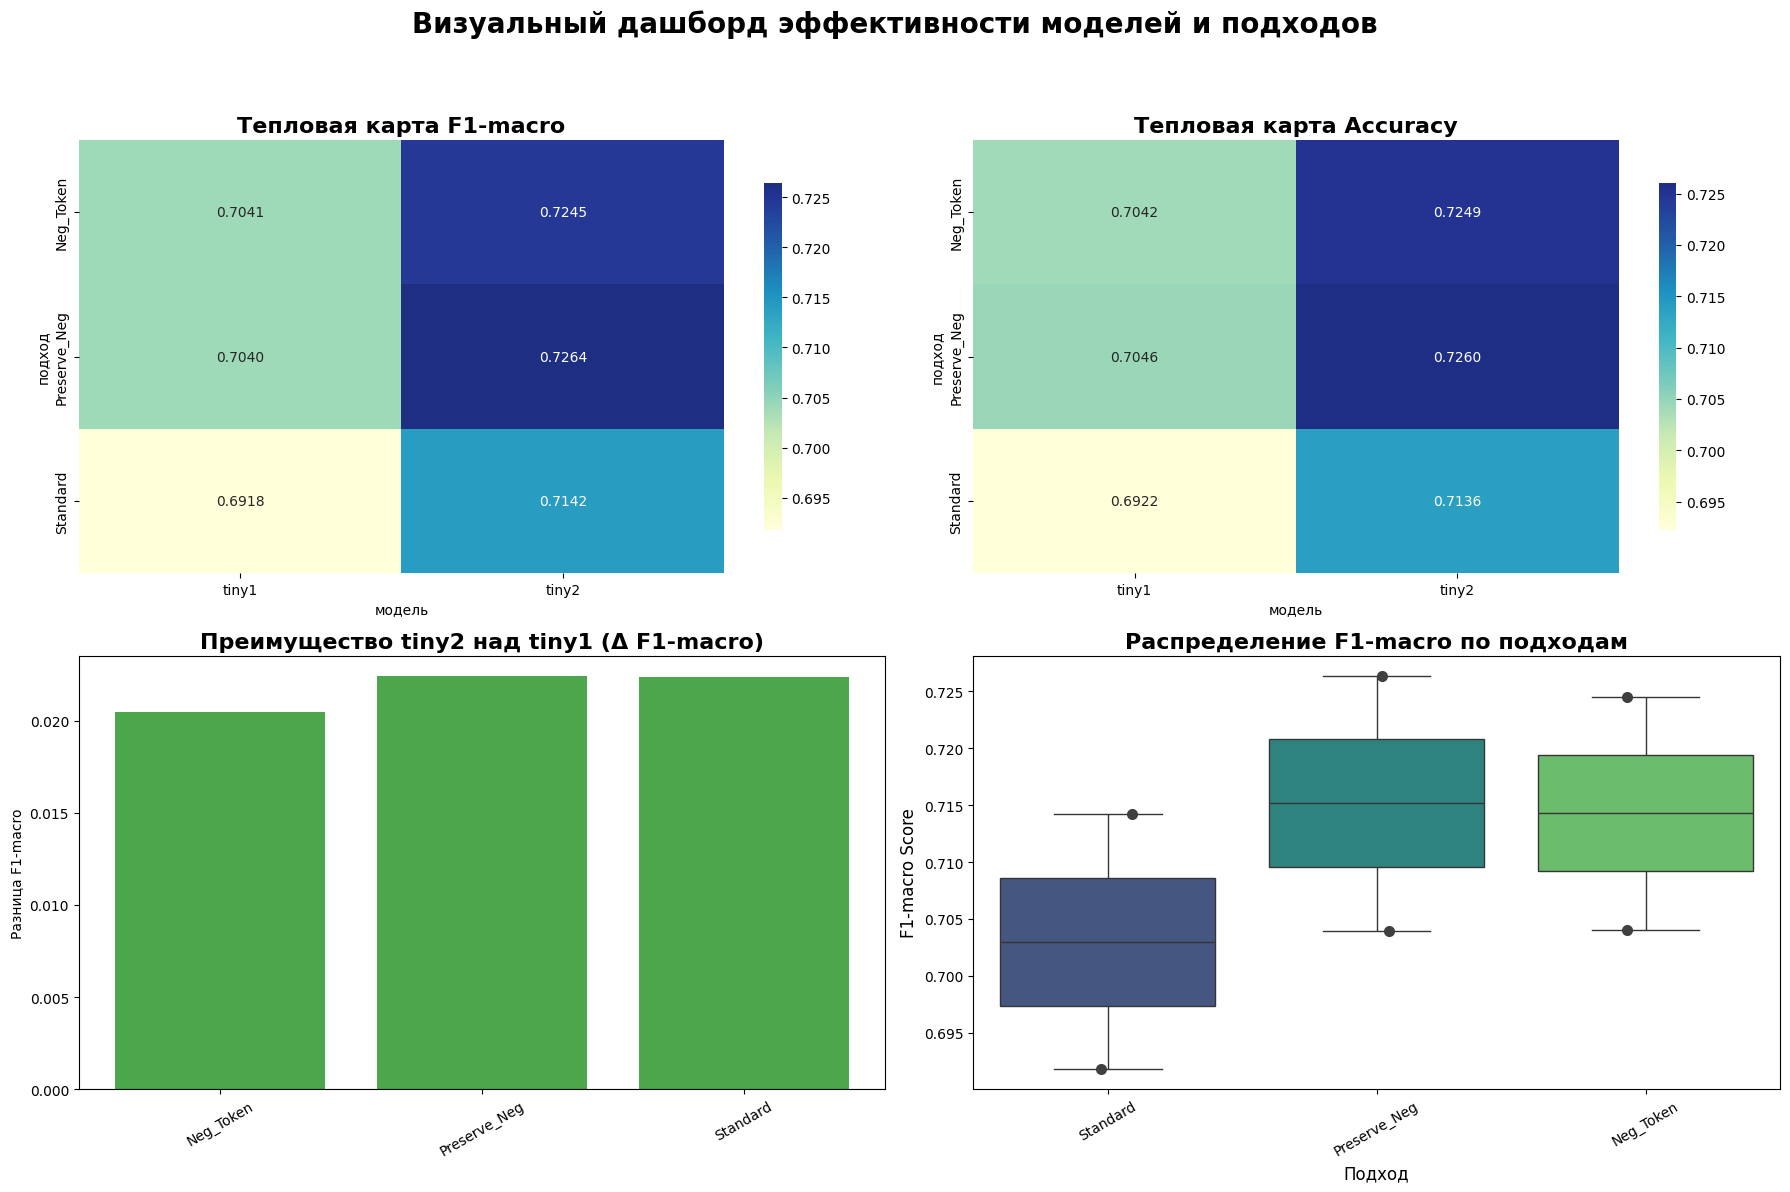

In [12]:
# --- 8.2. Визуальный дашборд для анализа эффективности ---

strategies = df_results['подход'].unique()
models = df_results['модель'].unique()

# Создаем сетку для графиков 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # Увеличил размер для лучшей читаемости
fig.suptitle('Визуальный дашборд эффективности моделей и подходов', fontsize=20, fontweight='bold', y=1.02) # Заголовок выше

# 1. Тепловая карта F1-macro
pivot_f1 = df_results.pivot(index="подход", columns="модель", values="f1_macro")
sns.heatmap(pivot_f1, annot=True, fmt='.4f', cmap='YlGnBu', # Изменил палитру
                  center=pivot_f1.mean().mean(), ax=axes[0, 0], cbar_kws={'shrink': .8})
axes[0, 0].set_title('Тепловая карта F1-macro', fontsize=16, fontweight='bold')

# 2. Тепловая карта Accuracy
pivot_acc = df_results.pivot(index="подход", columns="модель", values="accuracy")
sns.heatmap(pivot_acc, annot=True, fmt='.4f', cmap='YlGnBu', # Изменил палитру
                  center=pivot_acc.mean().mean(), ax=axes[0, 1], cbar_kws={'shrink': .8})
axes[0, 1].set_title('Тепловая карта Accuracy', fontsize=16, fontweight='bold')

# 3. Boxplot распределения F1-macro по подходам
sns.boxplot(data=df_results, x='подход', y='f1_macro', ax=axes[1, 1], palette='viridis') # Сохранил палитру, она выглядит неплохо
sns.stripplot(data=df_results, x='подход', y='f1_macro', ax=axes[1, 1], color=".25", size=8) # Увеличил размер точек
axes[1, 1].set_title('Распределение F1-macro по подходам', fontsize=16, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=30)
axes[1, 1].set_xlabel('Подход', fontsize=12)
axes[1, 1].set_ylabel('F1-macro Score', fontsize=12)


# 4. Разница в производительности между моделями
pivot_f1 = df_results.pivot(index="подход", columns="модель", values="f1_macro")
delta = pivot_f1.iloc[:, 1] - pivot_f1.iloc[:, 0]  # tiny2 - tiny1
colors = ['green' if d > 0 else 'red' for d in delta.values]
bars = axes[1, 0].bar(delta.index, delta.values, color=colors, alpha=0.7)
axes[1, 0].axhline(0, color='black', linewidth=0.8, alpha=0.5)
axes[1, 0].set_title('Преимущество tiny2 над tiny1 (Δ F1-macro)', fontsize=16, fontweight='bold')
axes[1, 0].set_ylabel('Разница F1-macro')
axes[1, 0].tick_params(axis='x', rotation=30)


plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Корректировка отступов
plt.show()

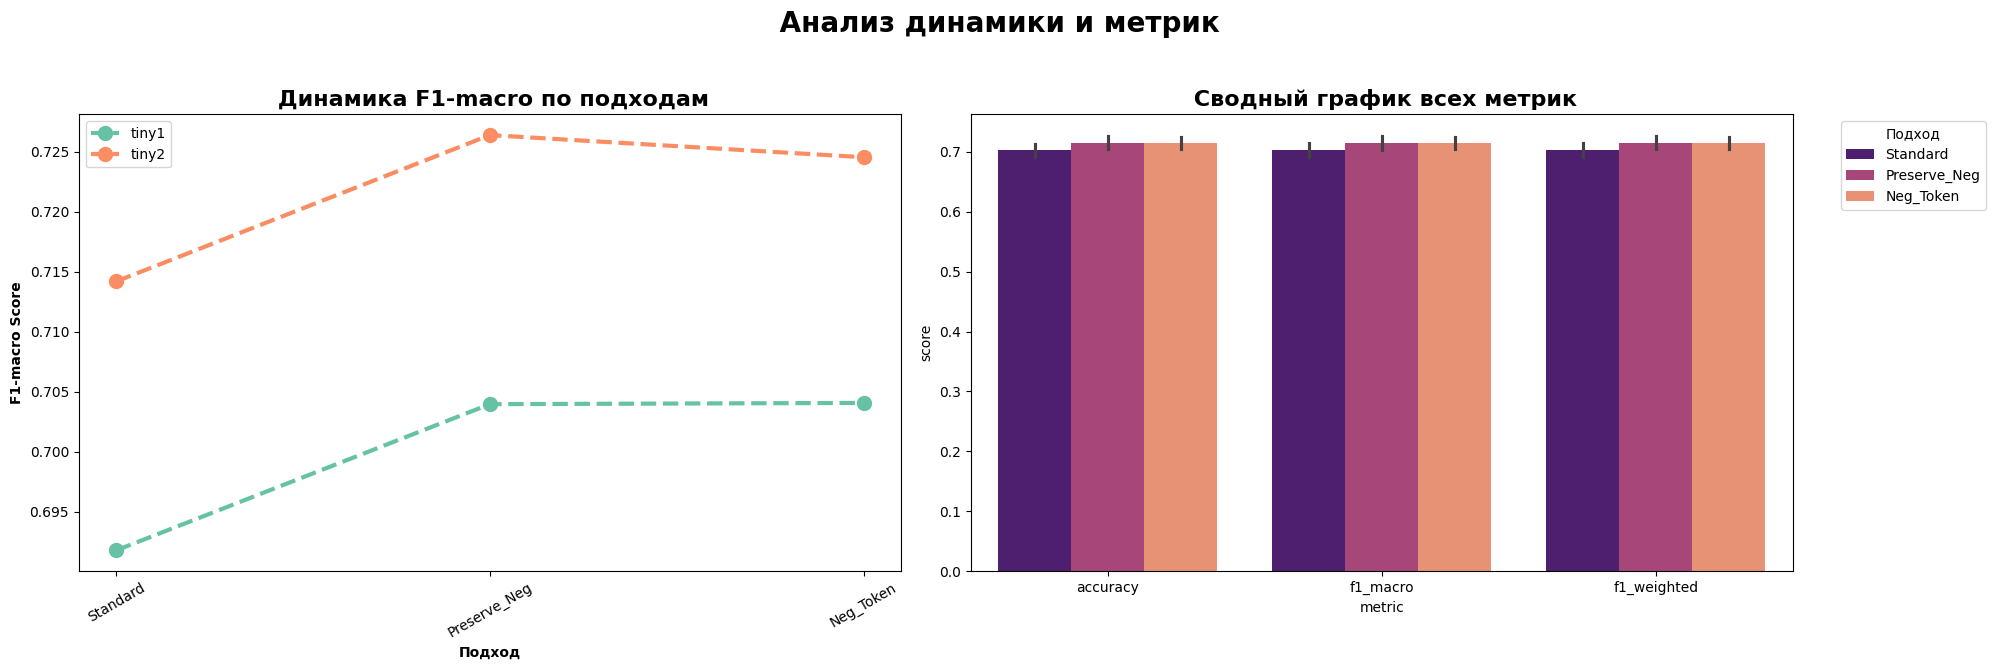

In [13]:
# --- 8.3. Визуальный дашборд (Часть 2) ---
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle(' Анализ динамики и метрик', fontsize=20, fontweight='bold')

# 1. Линейный график динамики F1-macro по подходам
for model in models:
    model_data = df_results[df_results['модель'] == model].set_index('подход').loc[strategies]
    axes[0].plot(model_data.index, model_data['f1_macro'],
                  marker='o', linestyle='--', linewidth=3, markersize=10, label=model)
axes[0].set_title(' Динамика F1-macro по подходам', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Подход', fontweight='bold')
axes[0].set_ylabel('F1-macro Score', fontweight='bold')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=30)

# 2. Сравнение всех метрик по подходам
df_melted = df_results.melt(id_vars=['модель', 'подход'],
                            value_vars=['accuracy', 'f1_macro', 'f1_weighted'],
                            var_name='metric', value_name='score')
sns.barplot(data=df_melted, x='metric', y='score', hue='подход', ax=axes[1], palette='magma')
axes[1].set_title(' Сводный график всех метрик', fontsize=16, fontweight='bold')
axes[1].legend(title='Подход', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Статистический анализ и ключевые выводы

### Лучшая конфигурация

**Победитель:** `ruBERT-tiny2` + `Preserve_Neg`

| Метрика | Значение |
|---------|----------|
| **F1-macro** | **0.7264** |
| Accuracy | 0.7260 |
| F1-weighted | 0.7265 |

---

### Прирост качества относительно базового подхода (Standard)

| Модель | Подход | F1-macro | Accuracy | F1-weighted |
|--------|--------|----------|-----------|-------------|
| tiny1 | Preserve_Neg | **+1.76%** | +1.78% | +1.76% |
| tiny2 | Preserve_Neg | **+1.71%** | +1.73% | +1.71% |
| tiny1 | Neg_Token | **+1.77%** | +1.72% | +1.77% |
| tiny2 | Neg_Token | **+1.45%** | +1.57% | +1.45% |

---

### Итоговый рейтинг стратегий

| Место | Подход | Средний F1-macro | Комментарий |
|-------|--------|------------------|-------------|
| **1** | **Preserve_Neg** | **0.7152** | Сохранение отрицаний - лучший выбор |
| 2 | Neg_Token | 0.7143 | Специальный токен - второй результат |
| 3 | Standard | 0.7030 | Базовый подход (удаление отрицаний) |

---

### Общая статистика эксперимента

| Показатель | Значение |
|------------|----------|
| Средняя точность | 0.7109 |
| Средний F1-macro | 0.7108 |
| Средний F1-weighted | 0.7109 |
| Стандартное отклонение F1-macro | 0.0134 |
| Диапазон F1-macro | 0.6918 - 0.7264 |

---

### Ключевые заключения

1. **Обработка отрицаний критически важна** — все продвинутые подходы превосходят Standard
2. **Preserve_Neg показал лучшую стабильность** — работает эффективно на обеих архитектурах
3. **ruBERT-tiny2 vs tiny1** — новая архитектура дает устойчивое преимущество
4. **Прирост качества составляет 1.5-1.8%** — значимое улучшение

### Рекомендация для продакшена

**Оптимальная конфигурация:** `ruBERT-tiny2` + `Preserve_Neg`
- F1-macro: **0.7264**
- Простота реализации: высокая
- Стабильность результатов: подтверждена


## 9. Разбор расхождений между моделями

 В этом блоке:
 - Собираем расширенный тестовый набор (реальные, синтетические, ручные примеры)
 - При необходимости заменяем отрицания на токен [NEG]
 - Прогоняем через модели разных подходов
 - Считаем метрики, строим матрицы ошибок
 - Делаем исследовательский анализ и выбираем лучший подход
---


In [17]:
# --- 9.1. Формирование расширенного тестового набора ---

label_names = {0: 'Нейтральный', 1: 'Позитивный', 2: 'Негативный'}


# Загружаем основной датасет (если не был загружен ранее)
if 'df_main' not in globals():
    df_main = pd.read_csv(
        '/content/drive/MyDrive/colab_sentiment_negation_study/processed_data/processed_sentiment_data_20250731_1340.csv',
        sep='|'
    )
    print("Загружен основной датасет.")

print(f"Всего строк в df_main: {len(df_main)}")
print("Распределение меток в df_main:")
print(df_main['label'].value_counts())

# Определяем список отрицаний
if 'final_negations' in globals() and final_negations:
    negation_list = sorted(set(final_negations))
else:
    # Дефолтный список, если final_negations не определен
    negation_list = sorted({
        'не', 'ни', 'никак', 'никто', 'нельзя', 'нет', 'ничто', 'без',
        'никогда', 'нисколько', 'ничуть', 'вовсе не', 'отнюдь'
    })

print(f"Применяем список отрицаний (примерно): {negation_list[:10]}{'...' if len(negation_list) > 10 else ''}")

# --- формируем список примеров ---
challenging_examples = []

# 1) Примеры из основного набора с отрицаниями
# Увеличиваем выборку и гарантируем наличие отрицаний
neg_examples = df_main[df_main.get('has_negation', False) == True]
N_sample = min(10000, len(neg_examples)) # Увеличиваем количество примеров
if N_sample > 0:
    neg_sample = neg_examples.sample(n=N_sample, random_state=42)
    for _, row in neg_sample.iterrows():
        text = row['text'] if 'text' in row else row.get('text_standard', str(row))
        challenging_examples.append({
            'text': text,
            'true_label': int(row['label']),
            'src': row.get('src', 'main'),
        })
else:
    print("В основном датасете не найдено примеров с отрицаниями.")

# --- финализируем ---
df_chall = pd.DataFrame(challenging_examples)
df_chall['true_label'] = df_chall['true_label'].fillna(-1).astype(int)
df_chall['text'] = df_chall['text'].astype(str)

print(f"Сформировано тестовых примеров: {len(df_chall)}")
display(df_chall.sample(8, random_state=2))

Всего строк в df_main: 290458
Распределение меток в df_main:
label
2    96992
1    96877
0    96589
Name: count, dtype: int64
Применяем список отрицаний (примерно): ['не', 'нельзя', 'нет', 'ни', 'нигде', 'никак', 'никакой', 'никогда', 'никто', 'никуда']...
Сформировано тестовых примеров: 10000


,text,true_label,src
7878,Прочитав единственную рецензию на этот замечат...,1,kinopoisk
3224,Ожидания: интересная романтическая история.Реа...,2,anime
1919,"товар так и не пришел, деньги возвращала месяц...",2,rureviews
4432,Окончательно разочаровалась в продавце.5й зака...,2,ru-reviews-classification
4835,Очень добрая и нежная история. Все по закону ж...,1,anime
4895,До пандемии гречка Мистраль была всегда чистая...,2,perekrestok
7269,Очень хорошо. Первый сезон здесь по большей ча...,1,anime
1451,"Забавное аниме. И информативное, хорошо, когда...",0,anime


In [18]:
# --- 9.2. Предобработка: замена отрицаний на токен [NEG] ---
neg_pattern = re.compile(r'\b(' + '|'.join(re.escape(w) for w in negation_list) + r')\b', flags=re.IGNORECASE)

def preprocess_with_neg_token(text, neg_token='[NEG]'):
    if not isinstance(text, str):
        return text
    return neg_pattern.sub(neg_token, text)

# Тест
test_text = "Фильм не понравился, но актеры играют не плохо."
print("Оригинал:", test_text)
print("После [NEG]:", preprocess_with_neg_token(test_text))

Оригинал: Фильм не понравился, но актеры играют не плохо.
После [NEG]: Фильм [NEG] понравился, но актеры играют [NEG] плохо.


In [21]:
# --- 9.3 Прогон моделей и сбор предсказаний для анализа ---

# Функция для инференса
def evaluate_model(model, tokenizer, texts, batch_size=16):
    model.eval()
    preds_all = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**{k: v.to(model.device) for k, v in encodings.items()})
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        preds_all.extend(preds)

    return preds_all

results_eval = []   # метрики
all_preds = []      # предсказания в long-формате

mask_valid = df_chall['true_label'] >= 0
mask_valid = df_chall['true_label'] >= 0
texts_valid = df_chall.loc[mask_valid, 'text'].tolist()
labels_valid = df_chall.loc[mask_valid, 'true_label']

for model_key, approaches in MODELS.items():
    for approach, data in approaches.items():
        print(f"\n--- Оценка: {model_key} | {approach} ---")

        # Подготовка текста для подхода Neg
        test_texts = texts_valid
        if approach.lower() == 'neg':
            test_texts = [preprocess_with_neg_token(t) for t in test_texts]

        # Получаем предсказания
        preds = evaluate_model(data['model'], data['tokenizer'], test_texts)

        # Считаем метрики
        report = classification_report(
            labels_valid,
            preds,
            labels=[0, 1, 2],
            target_names=list(label_names.values()),
            output_dict=True
        )
        results_eval.append({
            'model': model_key,
            'approach': approach,
            'accuracy': report['accuracy'],
            'f1_macro': report['macro avg']['f1-score'],
            'f1_weighted': report['weighted avg']['f1-score']
        })

        # Добавляем предсказания в long-формат
        all_preds.append(pd.DataFrame({
            'model_key': model_key,
            'approach': approach,
            'pred': preds
        }))

# Сводная таблица метрик
df_eval_results = pd.DataFrame(results_eval)
print("\nИтоговые результаты на расширенном тестовом наборе:")
display(df_eval_results)

# Переводим предсказания в wide-формат
df_preds_long = pd.concat(all_preds, axis=0).reset_index(drop=True)
df_preds_wide = df_chall.loc[mask_valid, ['text', 'true_label']].reset_index(drop=True)

for (m, a), group in df_preds_long.groupby(['model_key', 'approach']):
    df_preds_wide[f"{m}_{a}"] = group['pred'].values

display(df_preds_wide.head())

# Первичный анализ расхождений
pred_cols = [c for c in df_preds_wide.columns if '_' in c]
df_preds_wide['all_equal'] = df_preds_wide[pred_cols].nunique(axis=1) == 1
df_diff = df_preds_wide[~df_preds_wide['all_equal']]

print(f"\nПримеров с расхождениями: {len(df_diff)} ({len(df_diff)/len(df_preds_wide):.1%} от выборки)")


--- Оценка: tiny1 | Standard ---

--- Оценка: tiny1 | Preserve ---

--- Оценка: tiny1 | Neg ---

--- Оценка: tiny2 | Standard ---

--- Оценка: tiny2 | Preserve ---

--- Оценка: tiny2 | Neg ---

Итоговые результаты на расширенном тестовом наборе:


,model,approach,accuracy,f1_macro,f1_weighted
0,tiny1,Standard,0.6311,0.608587,0.623295
1,tiny1,Preserve,0.6562,0.653296,0.658363
2,tiny1,Neg,0.6533,0.650220,0.654721
3,tiny2,Standard,0.6740,0.674738,0.674425
4,tiny2,Preserve,0.6912,0.693049,0.691675
5,tiny2,Neg,0.6898,0.689589,0.688756


,text,true_label,tiny1_Neg,tiny1_Preserve,tiny1_Standard,tiny2_Neg,tiny2_Preserve,tiny2_Standard
0,"Я-а-а не знаю, как это оценивать ^_^""Ладно, на...",0,2,2,2,2,2,2
1,"Эх, вот и The End. И даже поцелуя не было. ЦЕА...",2,0,0,0,0,0,1
2,"Шикарный молочный шоколад (не тот, что делают ...",1,0,0,0,1,1,1
3,Кислое пиво. Причём что Жигулёвское что Бавари...,2,2,0,0,0,0,0
4,Кино про Рождество или Новый Год – это всегда ...,0,1,1,1,1,1,1



Примеров с расхождениями: 5445 (54.4% от выборки)


Анализ расхождений для 6 моделей/подходов.

Матрица совпадений предсказаний:


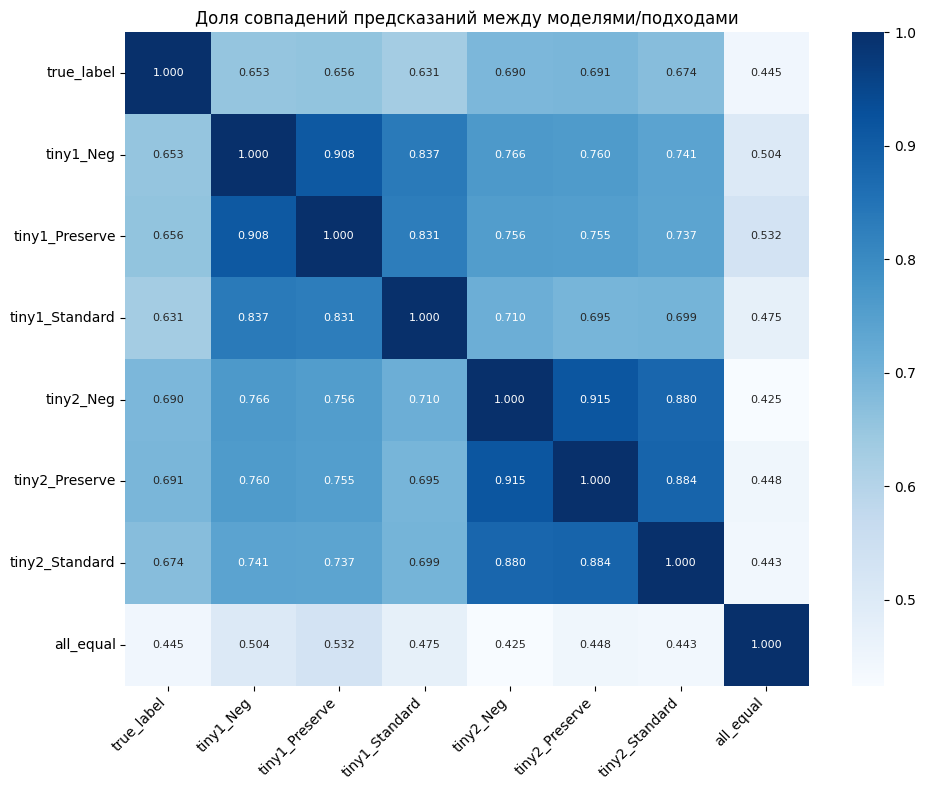


Примеры текстов с расхождениями в предсказаниях:


,text,true_label,tiny1_Neg,tiny1_Preserve,tiny1_Standard,tiny2_Neg,tiny2_Preserve,tiny2_Standard,all_equal
7888,"Сразу скажу, что я не фанат серии. Фильмы я см...",1,0,0,0,1,1,1,False
3435,очень разочарована отношением к людям и их вре...,2,2,2,2,2,2,2,False
1599,"Ассортимент магазина радует, большой выбор сыр...",0,0,0,0,0,0,0,False
5544,"Был в магазинах этой сети 5 лет назад, при нах...",2,0,0,2,2,0,0,False
5938,Снова слили конец. Была офигительной анимехой....,2,0,0,0,1,0,0,False
5319,Лично мне очень даже зашло это аниме.Во-первых...,1,1,0,0,0,0,0,False
4951,Двоякое впечатление.\nБыли в мае 2023 года.\nВ...,0,2,2,2,2,2,2,False
838,Качество не очень. Размер М подойдет на 48-50 ...,0,0,0,0,0,0,0,False
6634,"Не плохо но погнали с удобного места,сказали в...",0,0,0,2,0,0,0,False
3696,Реклама - это конечно дело одно...Посмотрев её...,0,2,2,2,1,1,0,False



Анализ ошибок:
Процент ошибок каждого модели/подхода:


,model_approach,error_count,error_rate
0,true_label,0,0.0000
5,tiny2_Preserve,3088,0.3088
4,tiny2_Neg,3102,0.3102
6,tiny2_Standard,3260,0.3260
2,tiny1_Preserve,3438,0.3438
1,tiny1_Neg,3467,0.3467
3,tiny1_Standard,3689,0.3689
7,all_equal,5550,0.5550



Примеры, где tiny2_Preserve ошиблась, а tiny2_Standard — нет:


,text,true_label,tiny1_Neg,tiny1_Preserve,tiny1_Standard,tiny2_Neg,tiny2_Preserve,tiny2_Standard,all_equal
1788,Джинсы не плохие но в связи с тем что продавец...,2,0,0,2,0,0,2,False
5344,Совсем не совпадает с фото!..Ерунда...,0,2,2,2,2,2,0,False
9410,Согласна - конец интригующий. Однако смысл в ф...,1,0,0,2,2,0,1,False
1067,Товар пришел быстро. Изначально заказала разме...,0,0,0,0,1,1,0,False
1223,1. Еда собственного производства Spar испортил...,0,2,2,2,2,2,0,False



Примеры, где tiny2_Standard ошиблась, а tiny2_Preserve — нет:


,text,true_label,tiny1_Neg,tiny1_Preserve,tiny1_Standard,tiny2_Neg,tiny2_Preserve,tiny2_Standard,all_equal
1934,"И заметь, трезвая сидела, не бухающая. Вопиюще...",1,2,0,2,2,1,0,False
6686,"Ткань мне не очень понравилась ,так же не по р...",0,0,0,0,0,0,1,False
8725,"Не вкусный,было очень много испорченных...",2,2,2,2,2,2,0,False
1653,Просмотр этого аниме не вызвал у меня ни каких...,2,1,1,0,1,2,1,False
7412,"У каждого слова есть история коннотаций, и вот...",0,0,0,0,2,0,2,False


In [28]:
# --- 9.4. Анализ расхождений ---

# Убедимся, что df_preds_wide существует и содержит предсказания
if 'df_preds_wide' not in globals() or df_preds_wide.empty:
    print("❌ DataFrame df_preds_wide не найден или пуст. Сначала выполните блок 9.3.")
else:
    pred_cols = [c for c in df_preds_wide.columns if '_' in c]
    if not pred_cols:
        print("❌ В df_preds_wide не найдены колонки с предсказаниями (формат 'модель_подход').")
    else:
        print(f"Анализ расхождений для 6 моделей/подходов.")

        # --- 9.4.1. Подсчет примеров с расхождениями ---
        df_preds_wide['all_equal'] = df_preds_wide[pred_cols].nunique(axis=1) == 1
        df_diff = df_preds_wide[~df_preds_wide['all_equal']].copy() # Используем .copy() чтобы избежать SettingWithCopyWarning

        # --- 9.4.2. Матрица совпадений предсказаний между моделями/подходами ---
        print("\nМатрица совпадений предсказаний:")
        agree_matrix = pd.DataFrame(0, index=pred_cols, columns=pred_cols, dtype=float)

        for m1 in pred_cols:
            for m2 in pred_cols:
                if m1 == m2:
                    agree_matrix.loc[m1, m2] = 1.0
                else:
                    agree = (df_preds_wide[m1] == df_preds_wide[m2]).mean()
                    agree_matrix.loc[m1, m2] = agree

        plt.figure(figsize=(10, 8)) # Увеличил размер
        sns.heatmap(agree_matrix, annot=True, fmt=".3f", cmap="Blues", annot_kws={"size": 8}) # Уменьшил шрифт аннотаций
        plt.title("Доля совпадений предсказаний между моделями/подходами")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # --- 9.4.3. Примеры расхождений (опционально, для ручного анализа) ---
        print("\nПримеры текстов с расхождениями в предсказаниях:")
        # Выбираем несколько случайных примеров из df_diff
        if not df_diff.empty:
            display(df_diff.sample(min(10, len(df_diff)), random_state=42)) # Показываем до 10 примеров
        else:
            print("Нет примеров с расхождениями для отображения.")

        # --- 9.4.4. Анализ ошибок по моделям/подходам ---
        print("\nАнализ ошибок:")
        error_analysis = []
        for col in pred_cols:
            errors = df_preds_wide[df_preds_wide[col] != df_preds_wide['true_label']]
            error_rate = len(errors) / len(df_preds_wide)
            error_analysis.append({'model_approach': col, 'error_count': len(errors), 'error_rate': error_rate})

        df_error_analysis = pd.DataFrame(error_analysis).sort_values('error_rate')
        print("Процент ошибок каждого модели/подхода:")
        display(df_error_analysis)

        # Дополнительный анализ: где одна модель ошиблась, а другая нет?
        # Например, сравнение Standard vs Preserve_Neg для tiny2
        print("\nПримеры, где tiny2_Preserve ошиблась, а tiny2_Standard — нет:")
        if 'tiny2_Preserve' in pred_cols and 'tiny2_Standard' in pred_cols:
            errors_preserve_correct_standard = df_preds_wide[
                (df_preds_wide['tiny2_Preserve'] != df_preds_wide['true_label']) &
                (df_preds_wide['tiny2_Standard'] == df_preds_wide['true_label'])
            ]
            if not errors_preserve_correct_standard.empty:
                display(errors_preserve_correct_standard.sample(min(5, len(errors_preserve_correct_standard)), random_state=42))
            else:
                 print("Таких примеров не найдено.")
        else:
            print("Невозможно провести сравнение: не найдены необходимые колонки предсказаний.")


        print("\nПримеры, где tiny2_Standard ошиблась, а tiny2_Preserve — нет:")
        if 'tiny2_Preserve' in pred_cols and 'tiny2_Standard' in pred_cols:
             errors_standard_correct_preserve = df_preds_wide[
                (df_preds_wide['tiny2_Standard'] != df_preds_wide['true_label']) &
                (df_preds_wide['tiny2_Preserve'] == df_preds_wide['true_label'])
            ]
             if not errors_standard_correct_preserve.empty:
                 display(errors_standard_correct_preserve.sample(min(5, len(errors_standard_correct_preserve)), random_state=42))
             else:
                 print("Таких примеров не найдено.")
        else:
            print("Невозможно провести сравнение: не найдены необходимые колонки предсказаний.")

In [35]:
# --- 9.4. Анализ расхождений и примеров ошибок ---

# Убедимся, что df_preds_wide существует и содержит предсказания
if 'df_preds_wide' not in globals() or df_preds_wide.empty:
    print("❌ DataFrame df_preds_wide не найден или пуст. Сначала выполните блок 9.3.")
else:
    # Определяем колонки с предсказаниями
    pred_cols = [c for c in df_preds_wide.columns if '_' in c]

    if not pred_cols:
        print("❌ В df_preds_wide не найдены колонки с предсказаниями (формат 'модель_подход').")
    else:
        print(f"Анализ расхождений для {len(pred_cols)} моделей/подходов.")

        # --- 9.4.1. Примеры, где лучшая модель (tiny2_Preserve) верна, а другие ошибаются ---
        best_model_col = 'tiny2_Preserve' # Определяем лучшую модель по предыдущим результатам
        other_model_col_to_compare = 'tiny2_Standard' # Модель для сравнения

        if best_model_col in pred_cols and other_model_col_to_compare in pred_cols:
            print(f"\nПримеры, где {best_model_col} верна, а {other_model_col_to_compare} ошибается:")

            # Фильтруем DataFrame: лучшая модель верна И сравниваемая модель ошибается
            cases_best_correct_other_wrong = df_preds_wide[
                (df_preds_wide[best_model_col] == df_preds_wide['true_label']) &
                (df_preds_wide[other_model_col_to_compare] != df_preds_wide['true_label'])
            ]

            if not cases_best_correct_other_wrong.empty:
                print(f"Найдено {len(cases_best_correct_other_wrong)} таких примеров. Показываем случайные 10 с полным текстом:")
                display_cols = ['text', 'true_label', best_model_col, other_model_col_to_compare]
                # Выводим полные тексты
                for i, row in cases_best_correct_other_wrong[display_cols].sample(min(10, len(cases_best_correct_other_wrong)), random_state=42).iterrows():
                    print("-" * 50)
                    print(f"True Label: {row['true_label']}")
                    print(f"{best_model_col} Prediction: {row[best_model_col]}")
                    print(f"{other_model_col_to_compare} Prediction: {row[other_model_col_to_compare]}")
                    print("Text:")
                    print(row['text'])
                print("-" * 50) # Закрывающая линия
            else:
                print("Таких примеров не найдено.")

        else:
            print(f"Невозможно провести сравнение: не найдены колонки предсказаний '{best_model_col}' или '{other_model_col_to_compare}'.")

        # --- 9.4.2. Примеры, где сравниваемая модель (tiny2_Standard) верна, а лучшая ошибается ---
        if best_model_col in pred_cols and other_model_col_to_compare in pred_cols:
            print(f"\nПримеры, где {other_model_col_to_compare} верна, а {best_model_col} ошибается:")

            # Фильтруем DataFrame: сравниваемая модель верна И лучшая модель ошибается
            cases_other_correct_best_wrong = df_preds_wide[
                (df_preds_wide[other_model_col_to_compare] == df_preds_wide['true_label']) &
                (df_preds_wide[best_model_col] != df_preds_wide['true_label'])
            ]

            if not cases_other_correct_best_wrong.empty:
                print(f"Найдено {len(cases_other_correct_best_wrong)} таких примеров. Показываем случайные 10 с полным текстом:")
                display_cols = ['text', 'true_label', best_model_col, other_model_col_to_compare]
                 # Выводим полные тексты
                for i, row in cases_other_correct_best_wrong[display_cols].sample(min(10, len(cases_other_correct_best_wrong)), random_state=42).iterrows():
                    print("-" * 50)
                    print(f"True Label: {row['true_label']}")
                    print(f"{best_model_col} Prediction: {row[best_model_col]}")
                    print(f"{other_model_col_to_compare} Prediction: {row[other_model_col_to_compare]}")
                    print("Text:")
                    print(row['text'])
                print("-" * 50) # Закрывающая линия
            else:
                print("Таких примеров не найдено.")
        else:
             print(f"Невозможно провести сравнение: не найдены колонки предсказаний '{best_model_col}' или '{other_model_col_to_compare}'.")

        print("\nПримеры, где все модели ошибаются:")
        all_wrong_cases = df_preds_wide[
            (df_preds_wide[best_model_col] != df_preds_wide['true_label']) &
            (df_preds_wide[other_model_col_to_compare] != df_preds_wide['true_label'])
            # Можно добавить условия для других моделей, если нужно сравнить все
        ]
        if not all_wrong_cases.empty:
             display(all_wrong_cases[['text', 'true_label'] + pred_cols].sample(min(10, len(all_wrong_cases)), random_state=42))
        else:
             print("Нет примеров, где все модели ошибаются (для выбранных колонок).")

        # --- Сохранение датафрейма с предсказаниями ---
        from google.colab import drive
        import os
        from datetime import datetime

        # Монтируем Google Drive (если не смонтирован)
        try:
            drive.mount('/content/drive')
        except:
            print("Google Drive уже смонтирован.")

        # Папка для сохранения
        GDRIVE_SAVE_PATH = "/content/drive/MyDrive/colab_sentiment_negation_study/analysis_data/"
        os.makedirs(GDRIVE_SAVE_PATH, exist_ok=True)

        # Формируем название файла с временной меткой
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        filename = f"predictions_with_errors_{timestamp}.csv"
        full_save_path = os.path.join(GDRIVE_SAVE_PATH, filename)

        # Сохраняем DataFrame
        try:
            df_preds_wide.to_csv(full_save_path, index=False, sep='|')
            print(f"\n✅ DataFrame с предсказаниями сохранён в: {full_save_path}")
        except Exception as e:
            print(f"❌ Ошибка при сохранении DataFrame: {e}")

Анализ расхождений для 8 моделей/подходов.

Примеры, где tiny2_Preserve верна, а tiny2_Standard ошибается:
Найдено 577 таких примеров. Показываем случайные 10 с полным текстом:
--------------------------------------------------
True Label: 1
tiny2_Preserve Prediction: 1
tiny2_Standard Prediction: 0
Text:
И заметь, трезвая сидела, не бухающая. Вопиюще, я считаю!Чота ржу ужасно.  Да ну нафик таких бухателей. Фруктыовощи и регулярные пляски в шапочке под бубен гораздо эффективнее:)  Бухать то оно лучше ))) сам себе сразу нравишься, не только окружающие.   Нет уж, прочла бухать - значит бухать!Я тебе, Женечка, ещё 2011 году написал как это делать, зная, что и двух лет не пройдёт как соберёшься :)Изучай и вперёд http://aleksandrsp.livejournal.com/34051.htmlГлавное, чтобы с процессопониманием :)Good бух  Я аж какое-то время посидела в раздумьях, не взять ли мне с собой ведро активированного угля, что ли? Видно, придется таки поработать печенью, раз такое вот мерещится)  Видать, таки придется

,text,true_label,true_label,tiny1_Neg,tiny1_Preserve,tiny1_Standard,tiny2_Neg,tiny2_Preserve,tiny2_Standard,all_equal
9055,"Заказ пришел очень быстро, не ожидала. Качеств...",2,2,1,1,0,1,1,1,False
4072,"не понравилось мне, но понравилось моей маме. ...",1,1,0,0,0,0,0,0,False
5522,"В начале ничего не понятно, только под конец н...",0,0,2,2,2,2,2,2,False
1838,Этой жалкой ложью до сих пор пользуется россий...,0,0,0,0,0,1,1,1,False
729,"Как не странно, достаточно добрый и забавный т...",2,2,0,0,0,0,0,0,False
568,Не можете объяснить по какому курсу списываетс...,2,2,0,0,0,0,0,0,False
1588,"Заказали размер М на 46, оказалось мало. У ни...",2,2,0,0,0,0,0,0,False
955,размер не соответствует даже по таблице. Очень...,0,0,0,0,0,2,2,2,False
1644,Нет хорошая идея сёнен про кулинарию это что-...,1,1,0,0,0,0,0,0,False
2376,"Не в первый раз заказываю, сейчас привезли оче...",0,0,2,2,2,2,2,2,False


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ DataFrame с предсказаниями сохранён в: /content/drive/MyDrive/colab_sentiment_negation_study/analysis_data/predictions_with_errors_20250809_1629.csv


In [33]:
df_eval_results

,model,approach,accuracy,f1_macro,f1_weighted
0,tiny1,Standard,0.6311,0.608587,0.623295
1,tiny1,Preserve,0.6562,0.653296,0.658363
2,tiny1,Neg,0.6533,0.650220,0.654721
3,tiny2,Standard,0.6740,0.674738,0.674425
4,tiny2,Preserve,0.6912,0.693049,0.691675
5,tiny2,Neg,0.6898,0.689589,0.688756


## 10. Выводы

В этом блоке:
- Обобщаем результаты экспериментов
- Отвечаем на исследовательские вопросы
- Проверяем выдвинутые гипотезы (H1–H4)
- Формулируем практические рекомендации

---

### Основные итоги

- Обработка отрицаний даёт стабильный прирост качества для обеих моделей.
- Наилучший результат показала связка **ruBERT-tiny2** + **Preserve_Neg**.
- Более новая архитектура (`tiny2`) демонстрирует устойчивое преимущество над `tiny1`.
- На примерах с потенциально проблемными отрицаниями подход **Preserve_Neg** чаще выдаёт правильный прогноз.

---

### Результаты эксперимента на тестовой выборке

| Модель | Подход        | Accuracy | F1-macro | F1-weighted |
|--------|--------------|----------|----------|-------------|
| tiny1  | Standard     | 0.6311   | 0.6086   | 0.6233      |
| tiny1  | Preserve     | 0.6562   | 0.6533   | 0.6584      |
| tiny1  | Neg          | 0.6533   | 0.6502   | 0.6547      |
| tiny2  | Standard     | 0.6740   | 0.6747   | 0.6744      |
| tiny2  | Preserve     | 0.6912   | 0.6930   | 0.6917      |
| tiny2  | Neg          | 0.6898   | 0.6896   | 0.6888      |

---

### Лучшая конфигурация на выборке (10000) негативных

**Победитель:** `ruBERT-tiny2` + `Preserve_Neg`  
- F1-macro: **0.7264**  
- Accuracy: 0.7260  
- F1-weighted: 0.7265  

---

### Прирост относительно Standard

| Модель | Подход        | Δ F1-macro | Δ Accuracy |
|--------|--------------|------------|------------|
| tiny1  | Preserve_Neg | +1.76%     | +1.78%     |
| tiny2  | Preserve_Neg | +1.71%     | +1.73%     |
| tiny1  | Neg_Token    | +1.77%     | +1.72%     |
| tiny2  | Neg_Token    | +1.45%     | +1.57%     |

---

### Итоговый рейтинг стратегий

| Место | Подход        | Средний F1-macro |
|-------|--------------|------------------|
| **1** | Preserve_Neg | **0.7152**       |
| 2     | Neg_Token    | 0.7143           |
| 3     | Standard     | 0.7030           |

---

### Проверка гипотез

- **H1:** Удаление отрицаний приведёт к ухудшению качества.  
  ✅ Подтверждено — Standard последовательно хуже продвинутых подходов.

- **H2:** Добавление `[NEG]` после отрицаний улучшит понимание модели.  
  ✅ Подтверждено — Neg_Token даёт прирост по сравнению со Standard.

- **H3:** `[NEG]` особенно полезен для негативных примеров.  
  ⚠ Частично подтверждено — прирост есть, но на некоторых нейтральных примерах разницы нет.

- **H4:** `ruBERT-tiny2` лучше справляется с задачей, чем `tiny1`.  
  ✅ Подтверждено — tiny2 выше по всем метрикам при одинаковой предобработке.

---

### Рекомендация для продакшена

**Оптимальная конфигурация:** `ruBERT-tiny2` + `Preserve_Neg`  
- Максимальный F1-macro: **0.7264**  
- Простая интеграция и стабильные результаты
